In [194]:
%matplotlib inline
import pandas as pd
import pickle
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.spatial import distance
import scipy.stats as st
from matplotlib.cm import get_cmap
from matplotlib import gridspec
import random

In [65]:
def input_paths(proj_path):

    input_paths_dict = {'QUIZC_cids_inchi_smiles_path': proj_path + 'QUIZC_drug_CIDs_inchi_smiles.csv',
                        'tool_path': proj_path + 'QUIZC_activityStats_nooutliers_df_besttool.csv',
                        'L1000_gene_info_path': proj_path + 'GSE92742_Broad_LINCS_gene_info.txt',
                        'L1000_cell_info_path': proj_path + 'GSE92742_Broad_LINCS_cell_info.txt',
                        'L1000_inst_info_path': proj_path + 'GSE92742_Broad_LINCS_inst_info.txt',
                        'L1000_pert_info_path': proj_path + 'GSE92742_Broad_LINCS_pert_info.txt',
                        'L1000_sig_info_path': proj_path + 'GSE92742_Broad_LINCS_sig_info.txt',

                        'pos_edges_dict_path': proj_path + 'cell_pos_edges_dict_75.pickle',
                        'neg_edges_dict_path': proj_path + 'cell_neg_edges_dict_75.pickle',
                        'drugs_dict_path': proj_path + 'cell_drugs_dict_75.pickle',

                        'cgp_dir': proj_path + 'c2.cgp.v7.1.symbols.gmt',

                        'Enrichr_GEO_up_path': proj_path + 'Disease_Perturbations_from_GEO_up.txt',
                        'Enrichr_GEO_dn_path': proj_path + 'Disease_Perturbations_from_GEO_down.txt',

                        'TTD_drugs_path': proj_path + 'P1-02-TTD_drug_download.txt',
                        'TTD_InChI2CID_path': proj_path + 'TTD_drugs_InChI2CID.txt',
                        'TTD_drug_target_path': proj_path + 'P1-07-Drug-TargetMapping.csv',
                        'TTD_target_path': proj_path + 'P1-01-TTD_target_download.txt',
                        'MODZ_networks_path': proj_path + 'MODZ_networks/',
                        'CD_networks_path': proj_path + 'CD_networks/'}
    
    return input_paths_dict

In [2]:
def import_L1000_metadata(L1000_gene_info_path, L1000_cell_info_path, L1000_inst_info_path, L1000_pert_info_path, L1000_sig_info_path):

    L1000_gene_info = pd.read_csv(L1000_gene_info_path, sep='\t', low_memory=False)
    L1000_cell_info = pd.read_csv(L1000_cell_info_path, sep='\t', low_memory=False)
    L1000_inst_info = pd.read_csv(L1000_inst_info_path, sep='\t', low_memory=False)
    L1000_pert_info = pd.read_csv(L1000_pert_info_path, sep='\t', low_memory=False)
    L1000_sig_info = pd.read_csv(L1000_sig_info_path, sep='\t', low_memory=False)
    
    return L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info

In [12]:
def process_QUIZC_output(pos_edges_dict_path, neg_edges_dict_path, drugs_dict_path, L1000_gene_info):

    with open(pos_edges_dict_path, 'rb') as handle:
        cell_pos_edges_dict = pickle.load(handle)
    with open(neg_edges_dict_path, 'rb') as handle:
        cell_neg_edges_dict = pickle.load(handle)
    with open(drugs_dict_path, 'rb') as handle:
        cell_drugs_dict = pickle.load(handle)     
    
    edgelist_df_dict = {}
    nodelist_df_dict = {}
    for c in tqdm(cell_drugs_dict.keys(), position=0, leave=True):

        pos_edges_df = pd.DataFrame(np.array([(i, j) for i, j in zip(cell_drugs_dict[c], cell_pos_edges_dict[c])])).explode(1)
        neg_edges_df = pd.DataFrame(np.array([(i, j) for i, j in zip(cell_drugs_dict[c], cell_neg_edges_dict[c])])).explode(1)

        pos_edges_df = pos_edges_df[~pd.isnull(pos_edges_df[1])]
        neg_edges_df = neg_edges_df[~pd.isnull(neg_edges_df[1])]

        pos_edges_df = pos_edges_df.reset_index(drop=True).rename(columns={0: 'Drug', 1: 'Target'})
        neg_edges_df = neg_edges_df.reset_index(drop=True).rename(columns={0: 'Drug', 1: 'Target'})

        pos_edges_df['Target'] = pos_edges_df['Target'].astype(int)
        neg_edges_df['Target'] = neg_edges_df['Target'].astype(int)

        pos_edges_df['Direction'] = 'Up'
        neg_edges_df['Direction'] = 'Down'

        pos_edges_df = pd.merge(pos_edges_df, L1000_gene_info, left_on='Target', 
                                right_on='pr_gene_id', how='left')[['Drug', 'pr_gene_symbol', 'Direction']]
        neg_edges_df = pd.merge(neg_edges_df, L1000_gene_info, left_on='Target', 
                                right_on='pr_gene_id', how='left')[['Drug', 'pr_gene_symbol', 'Direction']]

        all_edges_df = pd.concat([pos_edges_df, neg_edges_df]).rename(columns={'pr_gene_symbol': 'Target'})

        if len(all_edges_df) > 0:
            edgelist_df_dict[c] = all_edges_df 

            nodelist_df_dict_drug = pd.DataFrame(columns=['Id', 'Label', 'Type'])
            nodelist_df_dict_drug['Id'] = edgelist_df_dict[c]['Drug'].unique()
            nodelist_df_dict_drug['Label'] = edgelist_df_dict[c]['Drug'].unique()
            nodelist_df_dict_drug['Type'] = 'Drug'
            nodelist_df_dict_target = pd.DataFrame(columns=['Id', 'Label', 'Type'])
            nodelist_df_dict_target['Id'] = edgelist_df_dict[c]['Target'].unique()
            nodelist_df_dict_target['Label'] = edgelist_df_dict[c]['Target'].unique()
            nodelist_df_dict_target['Type'] = 'Gene'

            nodelist_df_dict[c] = pd.concat([nodelist_df_dict_drug, nodelist_df_dict_target])


    allcells = pd.DataFrame(sorted(list(nodelist_df_dict.keys())), columns=['Cell_type'])
    allgenes = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Gene']['Id']))), columns=['Gene_symbol'])
    alldrugs = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Drug']['Id']))), columns=['Pert_iname'])

    allnodes = pd.DataFrame(columns=['Node_name'])
    allnodes['Node_name'] = np.concatenate([allgenes['Gene_symbol'].values, alldrugs['Pert_iname'].values])
    allnodes['Node_ID'] = allnodes.index.values
    
    return edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes

In [13]:
def import_CD_MODZ_networks(path):
    nodelist_df_dict = {}
    edgelist_df_dict = {}
    for f in os.listdir(path):
        if f.endswith('_nodes.csv'):
            nodelist_df_dict[f.split('_')[1]] = pd.read_csv(path + f)
            nodelist_df_dict[f.split('_')[1]] = nodelist_df_dict[f.split('_')[1]].rename(columns={'ID': 'Id'})
        elif f.endswith('_edges_dir.csv'):
            edgelist_df_dict[f.split('_')[1]] = pd.read_csv(path + f)
            edgelist_df_dict[f.split('_')[1]] = edgelist_df_dict[f.split('_')[1]].rename(columns={'pert_iname': 'Drug', 'gene_name': 'Target'})[['Drug', 'Target', 'Direction']]

    allcells = pd.DataFrame(sorted(list(nodelist_df_dict.keys())), columns=['Cell_type'])
    allgenes = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Gene']['Id']))), 
                                columns=['Gene_symbol'])
    allgenes = allgenes.drop(0) # remove the row with gene name "-666", this is NA in Broad Institute convention
    alldrugs = pd.DataFrame(sorted(list(set(pd.concat(nodelist_df_dict)[pd.concat(nodelist_df_dict)['Type']=='Drug']['Id']))), 
                                columns=['Pert_iname'])

    allnodes = pd.DataFrame(columns=['Node_name'])
    allnodes['Node_name'] = np.concatenate([allgenes['Gene_symbol'].values, alldrugs['Pert_iname'].values])
    allnodes['Node_ID'] = allnodes.index.values
    
    return edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes

In [41]:
def generate_diG_dict(nodelist_df_dict, edgelist_df_dict, allcells):

    diG_dict = {}
    for c in tqdm(allcells['Cell_type'], position=0, leave=True):
        diG_dict[c] = nx.DiGraph()
        for ix, node in enumerate(nodelist_df_dict[c]['Id'].values):
            if nodelist_df_dict[c].iloc[ix]['Type']=='Drug':
                diG_dict[c].add_node(node, node_type='Drug', node_color='limegreen', node_size=150)
            elif nodelist_df_dict[c].iloc[ix]['Type']=='Gene':
                diG_dict[c].add_node(node, node_type='Gene', node_color='darkslateblue', node_size=50) 

        for edge in edgelist_df_dict[c].values:       
            if edge[2]=='Up':
                diG_dict[c].add_edge(edge[0], edge[1], edge_type='Up', edge_color='red')
            elif edge[2]=='Down':
                diG_dict[c].add_edge(edge[0], edge[1], edge_type='Down', edge_color='deepskyblue')
                
    return diG_dict

## Set file paths

In [38]:
proj_input_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses/'
proj_output_path = '/Users/ardahalu/Research/CICS/L1000_project/Pathopticon_all_analyses/Pathopticon_all_analyses_outputs/'
input_paths_dict = input_paths(proj_input_path)

## Import L1000 metadata

In [9]:
L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info = import_L1000_metadata(input_paths_dict['L1000_gene_info_path'], 
                                                                                                           input_paths_dict['L1000_cell_info_path'],
                                                                                                           input_paths_dict['L1000_inst_info_path'], 
                                                                                                           input_paths_dict['L1000_pert_info_path'], 
                                                                                                           input_paths_dict['L1000_sig_info_path'])

## Import cell type-specific gene-perturbation networks (QUIZ-C, MODZ, CD)

In [25]:
QUIZC_edgelist_df_dict, QUIZC_nodelist_df_dict, QUIZC_allcells, \
QUIZC_allgenes, QUIZC_alldrugs, QUIZC_allnodes = process_QUIZC_output(input_paths_dict['pos_edges_dict_path'], 
                                                                     input_paths_dict['neg_edges_dict_path'],
                                                                     input_paths_dict['drugs_dict_path'],
                                                                     L1000_gene_info)

MODZ_edgelist_df_dict, MODZ_nodelist_df_dict, MODZ_allcells, \
MODZ_allgenes, MODZ_alldrugs, MODZ_allnodes = import_CD_MODZ_networks(input_paths_dict['%s_networks_path' % 'LCB'])

CD_edgelist_df_dict, CD_nodelist_df_dict, CD_allcells, \
CD_allgenes, CD_alldrugs, CD_allnodes = import_CD_MODZ_networks(input_paths_dict['%s_networks_path' % 'CD'])

100%|██████████| 61/61 [00:03<00:00, 19.48it/s]


## Import Enrichr, TTD, MSigDB data

In [261]:
cgp_updn, cgp_updn_labels, cgp_updn_allgenes = process_MSigDB_CGP(input_paths_dict['cgp_dir'])
Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn = import_Enrichr_GEO(input_paths_dict['Enrichr_GEO_up_path'], 
                                                                                input_paths_dict['Enrichr_GEO_dn_path'])
TTD_drugs, TTD_InChI2CID, TTD_drugs_CID, TTD_drug_target, TTD_targID_dict = import_TDD(input_paths_dict['TTD_drugs_path'], 
                                                                                       input_paths_dict['TTD_InChI2CID_path'],
                                                                                       input_paths_dict['TTD_drug_target_path'], 
                                                                                       input_paths_dict['TTD_target_path'])

geneset_pert_iname_dict = get_MSigDB_geneset_targets(cgp_updn_labels, cgp_updn, TTD_targID_dict, TTD_drug_target, 
                                                     TTD_drugs_CID, QUIZC_cids_inchi_smiles)  

100%|██████████| 1058/1058 [00:09<00:00, 108.45it/s]


## Get benchmark genesets

In [305]:
benchmark_genesets = []
for geneset_name in geneset_pert_iname_dict.keys():
    if len(set(QUIZC_alldrugs['Pert_iname']) & set(MODZ_alldrugs['Pert_iname']) & set(CD_alldrugs['Pert_iname']) 
           & geneset_pert_iname_dict[geneset_name]) > 20:
        benchmark_genesets.append(geneset_name)

f = open(proj_output_path + 'benchmark_genesets.csv', 'w')
for g in benchmark_genesets:
    f.write('%s\n' % g)
f.close()

## Drug coverage in QUIZC/MODZ/CD networks (Figure 2A)
34/60 cell line-specific networks have over 80% drug coverage (i.e. over 80% of drugs tested in those cell lines are present in the corresponding drug-target QUIZC network). <br>
CD has slightly better coverage but overall it is comparable to QUIZC.

In [30]:
drug_coverage_df = pd.DataFrame(index=QUIZC_allcells['Cell_type'], columns=['L1000', 'QUIZC'])
for c in QUIZC_allcells['Cell_type']:
    drug_coverage_df.at[c, 'L1000'] = len(L1000_inst_info[(L1000_inst_info['cell_id']==c) & 
                                                          (L1000_inst_info['pert_type']=='trt_cp')]['pert_iname'].unique())
    drug_coverage_df.at[c, 'QUIZC'] = len(set(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Drug']['Id']))
for c in MODZ_allcells['Cell_type']:    
    drug_coverage_df.at[c, 'MODZ'] = len(set(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Drug']['Id']))
for c in CD_allcells['Cell_type']:    
    drug_coverage_df.at[c, 'CD'] = len(set(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Drug']['Id']))
    
drug_coverage_df['% (QUIZC)'] = 100.0 * drug_coverage_df['QUIZC']/ drug_coverage_df['L1000']
drug_coverage_df['% (MODZ)'] = 100.0 * drug_coverage_df['MODZ']/ drug_coverage_df['L1000']
drug_coverage_df['% (CD)'] = 100.0 * drug_coverage_df['CD']/ drug_coverage_df['L1000']

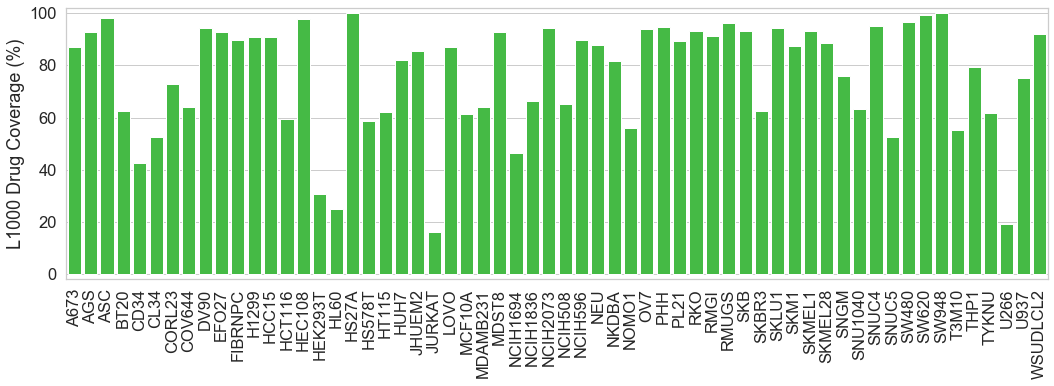

In [39]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.barplot(x=drug_coverage_df.index, y='% (QUIZC)', data=drug_coverage_df, color='limegreen')
    plt.xticks(rotation=90)
    plt.ylim(-2, 102)
    plt.tight_layout()
    plt.ylabel('L1000 Drug Coverage (%)')
    plt.xlabel('')
    plt.savefig(proj_output_path + 'Drug_coverage_QUIZC.pdf', format='pdf')
    plt.show()

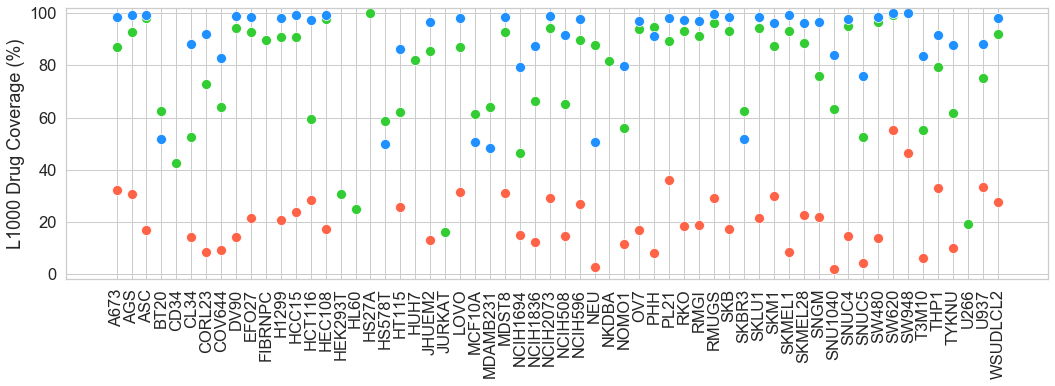

In [40]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.scatterplot(x=drug_coverage_df.index, y='% (QUIZC)', data=drug_coverage_df, color='limegreen', s=100)
    sns.scatterplot(x=drug_coverage_df.index, y='% (MODZ)', data=drug_coverage_df, color='tomato', s=100)
    sns.scatterplot(x=drug_coverage_df.index, y='% (CD)', data=drug_coverage_df,  color='dodgerblue', s=100)
    plt.xticks(rotation=90)
    plt.ylim(-2, 102)
    plt.tight_layout()
    plt.ylabel('L1000 Drug Coverage (%)')
    plt.xlabel('')
    plt.savefig(proj_output_path + 'Drug_coverage_all.pdf', format='pdf')
    plt.show()

## In-, out-degree vs number of cell lines (Figures 2B-C, Supplementary Figure 3)

In [44]:
QUIZC_diG_dict = generate_diG_dict(QUIZC_nodelist_df_dict, QUIZC_edgelist_df_dict, QUIZC_allcells)
MODZ_diG_dict = generate_diG_dict(MODZ_nodelist_df_dict, MODZ_edgelist_df_dict, MODZ_allcells)
CD_diG_dict = generate_diG_dict(CD_nodelist_df_dict, CD_edgelist_df_dict, CD_allcells)

100%|██████████| 51/51 [00:36<00:00,  1.40it/s]


### QUIZ-C

In [57]:
QUIZC_norm_in_degree_df = pd.DataFrame(index=QUIZC_allgenes['Gene_symbol'], columns=QUIZC_allcells['Cell_type'])
QUIZC_norm_out_degree_df = pd.DataFrame(index=QUIZC_alldrugs['Pert_iname'], columns=QUIZC_allcells['Cell_type'])

for c in tqdm(QUIZC_norm_in_degree_df.columns):
    QUIZC_norm_in_degree_df[c] = pd.Series(pd.DataFrame.from_dict(QUIZC_diG_dict[c].in_degree()).set_index(0)[1] / 
                                     len(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Drug']['Id'].unique()), 
                                           index=QUIZC_allgenes['Gene_symbol'])
    QUIZC_norm_out_degree_df[c] = pd.Series(pd.DataFrame.from_dict(QUIZC_diG_dict[c].out_degree()).set_index(0)[1] / 
                                      len(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Gene']['Id'].unique()), 
                                            index=QUIZC_alldrugs['Pert_iname'])
    
QUIZC_norm_in_degree_cellno_df = pd.DataFrame(index=QUIZC_allgenes['Gene_symbol'])
QUIZC_norm_in_degree_cellno_df['# cell lines gene is in'] = pd.Series(QUIZC_norm_in_degree_df.count(axis=1), 
                                                                      index=QUIZC_allgenes['Gene_symbol'])
QUIZC_norm_in_degree_cellno_df['mean norm. in-degree'] = pd.Series(QUIZC_norm_in_degree_df.mean(axis=1), 
                                                                   index=QUIZC_allgenes['Gene_symbol'])
QUIZC_norm_in_degree_cellno_df['norm. in-degree std.dev.'] = pd.Series(QUIZC_norm_in_degree_df.std(axis=1, ddof=0), 
                                                                       index=QUIZC_allgenes['Gene_symbol'])

QUIZC_norm_out_degree_cellno_df = pd.DataFrame(index=QUIZC_alldrugs['Pert_iname'])
QUIZC_norm_out_degree_cellno_df['# cell lines drug is in'] = pd.Series(QUIZC_norm_out_degree_df.count(axis=1), 
                                                                       index=QUIZC_alldrugs['Pert_iname'])
QUIZC_norm_out_degree_cellno_df['mean norm. out-degree'] = pd.Series(QUIZC_norm_out_degree_df.mean(axis=1), 
                                                                     index=QUIZC_alldrugs['Pert_iname'])
QUIZC_norm_out_degree_cellno_df['norm. out-degree std.dev.'] = pd.Series(QUIZC_norm_out_degree_df.std(axis=1, ddof=0), 
                                                                         index=QUIZC_alldrugs['Pert_iname'])

100%|██████████| 60/60 [00:01<00:00, 46.71it/s]


<Figure size 432x288 with 0 Axes>

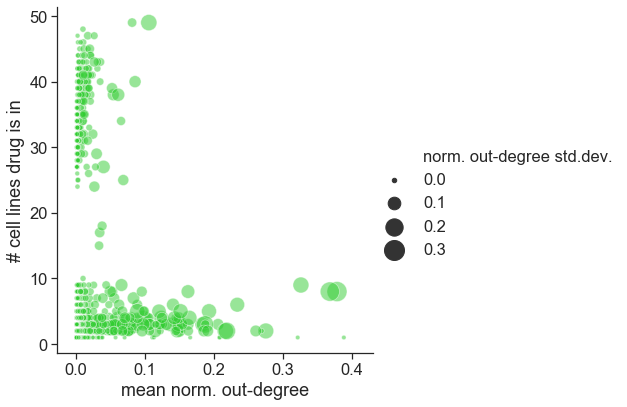

In [52]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    ax = sns.relplot(x='mean norm. out-degree', y='# cell lines drug is in', size='norm. out-degree std.dev.', 
                     sizes=(20, 400), alpha=.5, palette="muted",
                height=6, data=QUIZC_norm_out_degree_cellno_df, color='limegreen')
    plt.savefig(proj_output_path + 'QUIZC_norm_out-degree_cellno.pdf', format='pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

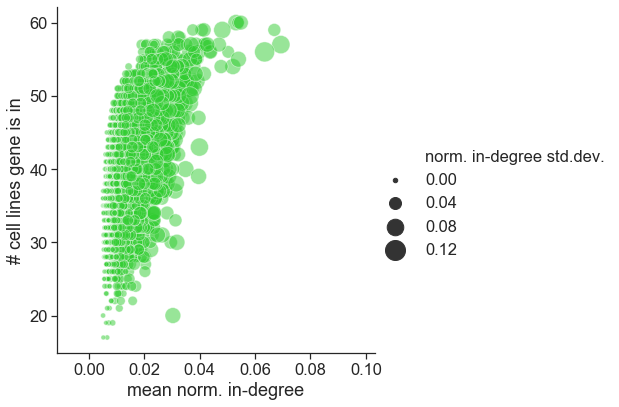

In [53]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    sns.relplot(x='mean norm. in-degree', y='# cell lines gene is in', size='norm. in-degree std.dev.', sizes=(20, 400), alpha=.5, palette="muted",
                height=6, data=QUIZC_norm_in_degree_cellno_df, color='limegreen')
    plt.savefig(proj_output_path + 'QUIZC_norm_in-degree_cellno.pdf', format='pdf')
    plt.show()

### MODZ

In [58]:
MODZ_norm_in_degree_df = pd.DataFrame(index=MODZ_allgenes['Gene_symbol'], columns=MODZ_allcells['Cell_type'])
MODZ_norm_out_degree_df = pd.DataFrame(index=MODZ_alldrugs['Pert_iname'], columns=MODZ_allcells['Cell_type'])

for c in tqdm(MODZ_norm_in_degree_df.columns):
    MODZ_norm_in_degree_df[c] = pd.Series(pd.DataFrame.from_dict(MODZ_diG_dict[c].in_degree()).set_index(0)[1] / 
                                     len(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Drug']['Id'].unique()), 
                                           index=MODZ_allgenes['Gene_symbol'])
    MODZ_norm_out_degree_df[c] = pd.Series(pd.DataFrame.from_dict(MODZ_diG_dict[c].out_degree()).set_index(0)[1] / 
                                      len(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Gene']['Id'].unique()), 
                                            index=MODZ_alldrugs['Pert_iname'])
    
MODZ_norm_in_degree_cellno_df = pd.DataFrame(index=MODZ_allgenes['Gene_symbol'])
MODZ_norm_in_degree_cellno_df['# cell lines gene is in'] = pd.Series(MODZ_norm_in_degree_df.count(axis=1), 
                                                                      index=MODZ_allgenes['Gene_symbol'])
MODZ_norm_in_degree_cellno_df['mean norm. in-degree'] = pd.Series(MODZ_norm_in_degree_df.mean(axis=1), 
                                                                   index=MODZ_allgenes['Gene_symbol'])
MODZ_norm_in_degree_cellno_df['norm. in-degree std.dev.'] = pd.Series(MODZ_norm_in_degree_df.std(axis=1, ddof=0), 
                                                                       index=MODZ_allgenes['Gene_symbol'])

MODZ_norm_out_degree_cellno_df = pd.DataFrame(index=MODZ_alldrugs['Pert_iname'])
MODZ_norm_out_degree_cellno_df['# cell lines drug is in'] = pd.Series(MODZ_norm_out_degree_df.count(axis=1), 
                                                                       index=MODZ_alldrugs['Pert_iname'])
MODZ_norm_out_degree_cellno_df['mean norm. out-degree'] = pd.Series(MODZ_norm_out_degree_df.mean(axis=1), 
                                                                     index=MODZ_alldrugs['Pert_iname'])
MODZ_norm_out_degree_cellno_df['norm. out-degree std.dev.'] = pd.Series(MODZ_norm_out_degree_df.std(axis=1, ddof=0), 
                                                                         index=MODZ_alldrugs['Pert_iname'])

100%|██████████| 51/51 [00:00<00:00, 66.28it/s]


<Figure size 432x288 with 0 Axes>

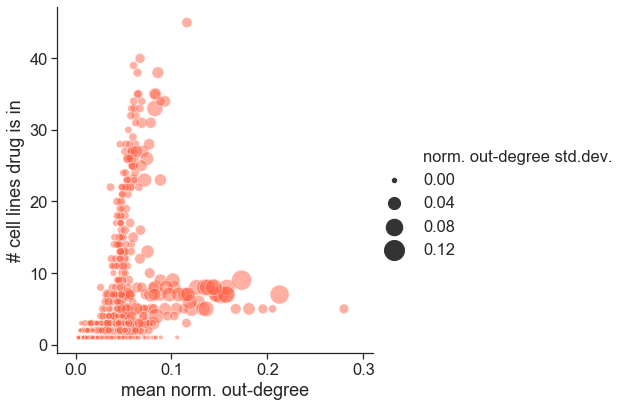

In [59]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    ax = sns.relplot(x='mean norm. out-degree', y='# cell lines drug is in', size='norm. out-degree std.dev.', 
                     sizes=(20, 400), alpha=.5, palette="muted",
                height=6, data=MODZ_norm_out_degree_cellno_df, color='tomato')
    plt.savefig(proj_output_path + 'MODZ_norm_out-degree_cellno.pdf', format='pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

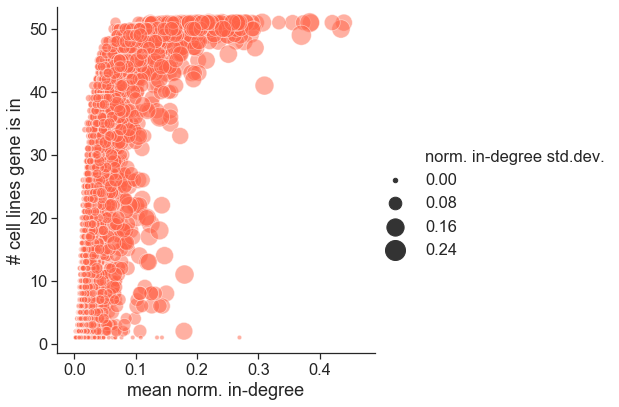

In [60]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    sns.relplot(x='mean norm. in-degree', y='# cell lines gene is in', size='norm. in-degree std.dev.', sizes=(20, 400), alpha=.5, palette="muted",
                height=6, data=MODZ_norm_in_degree_cellno_df, color='tomato')
    plt.savefig(proj_output_path + 'MODZ_norm_in-degree_cellno.pdf', format='pdf')
    plt.show()

### CD

In [61]:
CD_norm_in_degree_df = pd.DataFrame(index=CD_allgenes['Gene_symbol'], columns=CD_allcells['Cell_type'])
CD_norm_out_degree_df = pd.DataFrame(index=CD_alldrugs['Pert_iname'], columns=CD_allcells['Cell_type'])

for c in tqdm(CD_norm_in_degree_df.columns):
    CD_norm_in_degree_df[c] = pd.Series(pd.DataFrame.from_dict(CD_diG_dict[c].in_degree()).set_index(0)[1] / 
                                     len(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Drug']['Id'].unique()), 
                                           index=CD_allgenes['Gene_symbol'])
    CD_norm_out_degree_df[c] = pd.Series(pd.DataFrame.from_dict(CD_diG_dict[c].out_degree()).set_index(0)[1] / 
                                      len(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Gene']['Id'].unique()), 
                                            index=CD_alldrugs['Pert_iname'])
    
CD_norm_in_degree_cellno_df = pd.DataFrame(index=CD_allgenes['Gene_symbol'])
CD_norm_in_degree_cellno_df['# cell lines gene is in'] = pd.Series(CD_norm_in_degree_df.count(axis=1), 
                                                                      index=CD_allgenes['Gene_symbol'])
CD_norm_in_degree_cellno_df['mean norm. in-degree'] = pd.Series(CD_norm_in_degree_df.mean(axis=1), 
                                                                   index=CD_allgenes['Gene_symbol'])
CD_norm_in_degree_cellno_df['norm. in-degree std.dev.'] = pd.Series(CD_norm_in_degree_df.std(axis=1, ddof=0), 
                                                                       index=CD_allgenes['Gene_symbol'])

CD_norm_out_degree_cellno_df = pd.DataFrame(index=CD_alldrugs['Pert_iname'])
CD_norm_out_degree_cellno_df['# cell lines drug is in'] = pd.Series(CD_norm_out_degree_df.count(axis=1), 
                                                                       index=CD_alldrugs['Pert_iname'])
CD_norm_out_degree_cellno_df['mean norm. out-degree'] = pd.Series(CD_norm_out_degree_df.mean(axis=1), 
                                                                     index=CD_alldrugs['Pert_iname'])
CD_norm_out_degree_cellno_df['norm. out-degree std.dev.'] = pd.Series(CD_norm_out_degree_df.std(axis=1, ddof=0), 
                                                                         index=CD_alldrugs['Pert_iname'])

100%|██████████| 51/51 [00:00<00:00, 61.55it/s]


<Figure size 432x288 with 0 Axes>

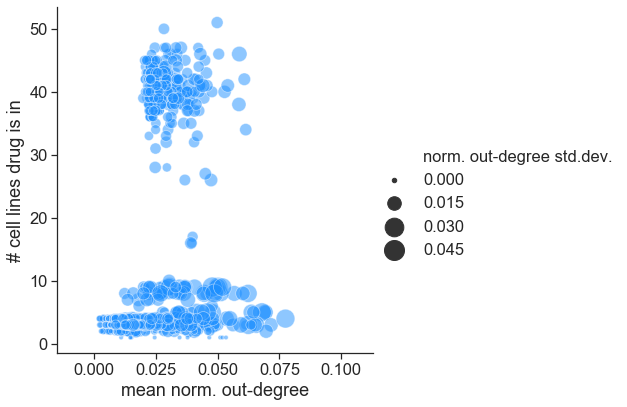

In [62]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    ax = sns.relplot(x='mean norm. out-degree', y='# cell lines drug is in', size='norm. out-degree std.dev.', 
                     sizes=(20, 400), alpha=.5, palette="muted",
                height=6, data=CD_norm_out_degree_cellno_df, color='dodgerblue')
    plt.savefig(proj_output_path + 'CD_norm_out-degree_cellno.pdf', format='pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

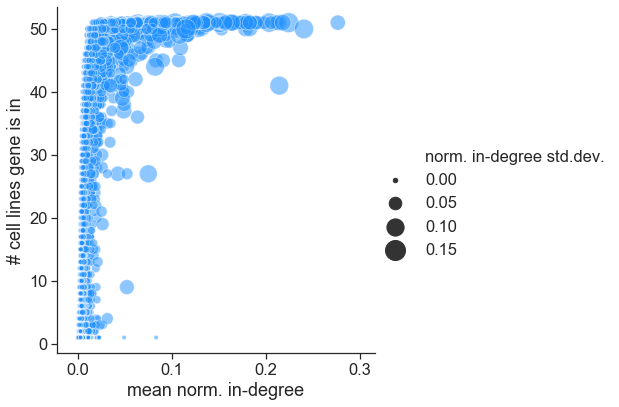

In [63]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    sns.relplot(x='mean norm. in-degree', y='# cell lines gene is in', size='norm. in-degree std.dev.', sizes=(20, 400), alpha=.5, palette="muted",
                height=6, data=CD_norm_in_degree_cellno_df, color='dodgerblue')
    plt.savefig(proj_output_path + 'CD_norm_in-degree_cellno.pdf', format='pdf')
    plt.show()

## Edge overlap between cell lines in QUIZC/MODZ/CD networks (Figure 2D, Supplementary Figure 4)

In [64]:
QUIZC_edge_overlap_df = pd.DataFrame(index=QUIZC_allcells['Cell_type'], columns=QUIZC_allcells['Cell_type'])
QUIZC_edge_concordance_df = pd.DataFrame(index=QUIZC_allcells['Cell_type'], columns=QUIZC_allcells['Cell_type'])
for c1 in tqdm(QUIZC_allcells['Cell_type']):
    for c2 in QUIZC_allcells['Cell_type']:
        inner = pd.merge(QUIZC_edgelist_df_dict[c1], QUIZC_edgelist_df_dict[c2], left_on=['Drug', 'Target'], right_on=['Drug', 'Target'], how='inner')
        outer = pd.merge(QUIZC_edgelist_df_dict[c1], QUIZC_edgelist_df_dict[c2], left_on=['Drug', 'Target'], right_on=['Drug', 'Target'], how='outer')
        inner_conc = pd.merge(QUIZC_edgelist_df_dict[c1], QUIZC_edgelist_df_dict[c2], left_on=['Drug', 'Target', 'Direction'], 
                              right_on=['Drug', 'Target', 'Direction'], how='inner')
        QUIZC_edge_overlap_df.at[c1, c2] = 1.0 * len(inner) / len(outer)   
        if len(inner) > 0:
            QUIZC_edge_concordance_df.at[c1, c2] = 100.0 * len(inner_conc) / len(inner)   

100%|██████████| 60/60 [02:46<00:00,  2.78s/it]


In [68]:
MODZ_edge_overlap_df = pd.DataFrame(index=MODZ_allcells['Cell_type'], columns=MODZ_allcells['Cell_type'])
MODZ_edge_concordance_df = pd.DataFrame(index=MODZ_allcells['Cell_type'], columns=MODZ_allcells['Cell_type'])
for c1 in tqdm(MODZ_allcells['Cell_type']):
    for c2 in MODZ_allcells['Cell_type']:
        inner = pd.merge(MODZ_edgelist_df_dict[c1], MODZ_edgelist_df_dict[c2], left_on=['Drug', 'Target'], right_on=['Drug', 'Target'], how='inner')
        outer = pd.merge(MODZ_edgelist_df_dict[c1], MODZ_edgelist_df_dict[c2], left_on=['Drug', 'Target'], right_on=['Drug', 'Target'], how='outer')
        inner_conc = pd.merge(MODZ_edgelist_df_dict[c1], MODZ_edgelist_df_dict[c2], left_on=['Drug', 'Target', 'Direction'], 
                              right_on=['Drug', 'Target', 'Direction'], how='inner')
        MODZ_edge_overlap_df.at[c1, c2] = 1.0 * len(inner) / len(outer) 
        if len(inner) > 0:
            MODZ_edge_concordance_df.at[c1, c2] = 100.0 * len(inner_conc) / len(inner)  

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


In [69]:
CD_edge_overlap_df = pd.DataFrame(index=CD_allcells['Cell_type'], columns=CD_allcells['Cell_type'])
CD_edge_concordance_df = pd.DataFrame(index=CD_allcells['Cell_type'], columns=CD_allcells['Cell_type'])
for c1 in tqdm(CD_allcells['Cell_type']):
    for c2 in CD_allcells['Cell_type']:
        inner = pd.merge(CD_edgelist_df_dict[c1], CD_edgelist_df_dict[c2], left_on=['Drug', 'Target'], right_on=['Drug', 'Target'], how='inner')
        outer = pd.merge(CD_edgelist_df_dict[c1], CD_edgelist_df_dict[c2], left_on=['Drug', 'Target'], right_on=['Drug', 'Target'], how='outer')
        inner_conc = pd.merge(CD_edgelist_df_dict[c1], CD_edgelist_df_dict[c2], left_on=['Drug', 'Target', 'Direction'], 
                              right_on=['Drug', 'Target', 'Direction'], how='inner')
        CD_edge_overlap_df.at[c1, c2] = 1.0 * len(inner) / len(outer) 
        if len(inner) > 0:
            CD_edge_concordance_df.at[c1, c2] = 100.0 * len(inner_conc) / len(inner)  

100%|██████████| 51/51 [02:25<00:00,  2.86s/it]


In [76]:
QUIZC_overlap_mat = QUIZC_edge_overlap_df.astype(float).values
row_linkage = hierarchy.linkage(distance.pdist(QUIZC_overlap_mat), method='ward')
Z = hierarchy.dendrogram(row_linkage, orientation='left', no_plot=True)
idx = Z['leaves']
QUIZC_overlap_mat = QUIZC_overlap_mat[idx, :]
QUIZC_overlap_mat = QUIZC_overlap_mat[:, idx]

MODZ_overlap_mat = MODZ_edge_overlap_df.astype(float).values
row_linkage = hierarchy.linkage(distance.pdist(MODZ_overlap_mat), method='ward')
Z = hierarchy.dendrogram(row_linkage, orientation='left', no_plot=True)
idx = Z['leaves']
MODZ_overlap_mat = MODZ_overlap_mat[idx, :]
MODZ_overlap_mat = MODZ_overlap_mat[:, idx]

CD_overlap_mat = CD_edge_overlap_df.astype(float).values
row_linkage = hierarchy.linkage(distance.pdist(CD_overlap_mat), method='ward')
Z = hierarchy.dendrogram(row_linkage, orientation='left', no_plot=True)
idx = Z['leaves']
CD_overlap_mat = CD_overlap_mat[idx, :]
CD_overlap_mat = CD_overlap_mat[:, idx]

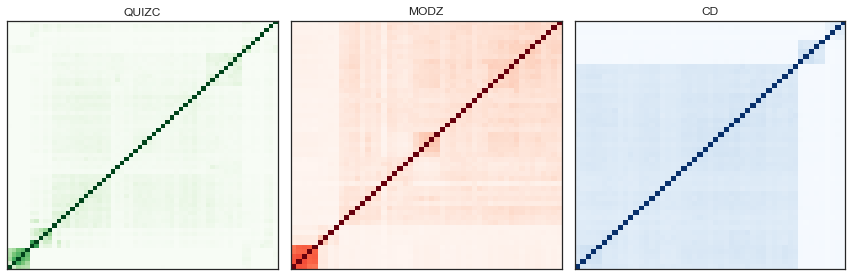

In [77]:
plt.figure(figsize=(12, 4))
sns.set(font_scale=1.0)
with sns.axes_style("white"):

    plt.subplot(1, 3, 1)
    plt.imshow(QUIZC_overlap_mat, aspect='auto', origin='lower', cmap='Greens', vmin=0.0, vmax=0.4)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title('QUIZC')
    plt.subplot(1, 3, 2)
    plt.imshow(MODZ_overlap_mat, aspect='auto', origin='lower', cmap='Reds', vmin=0.0, vmax=0.4)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title('MODZ')
    plt.subplot(1, 3, 3)
    plt.imshow(CD_overlap_mat, aspect='auto', origin='lower', cmap='Blues', vmin=0.0, vmax=0.4)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title('CD')
    
    plt.tight_layout()
    plt.savefig(proj_output_path + 'edge_overlap_all_heatmap.pdf', format='pdf')
    plt.show()

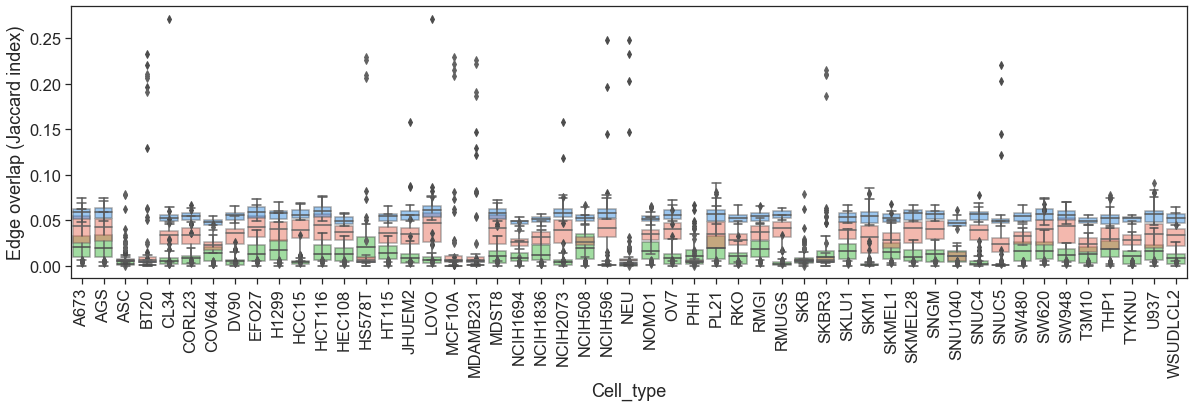

In [94]:
fig = plt.figure()
fig.set_size_inches(20, 5)
sns.set(font_scale=1.5)
with sns.axes_style("ticks"):
    sns.boxplot(QUIZC_allcells['Cell_type'], 
                [list(QUIZC_edge_overlap_df.loc[c][set(QUIZC_allcells['Cell_type']) - set([c])].values.astype(float)) for c in QUIZC_allcells['Cell_type']],
               color='limegreen', boxprops=dict(alpha=.5))
    sns.boxplot(MODZ_allcells['Cell_type'], 
                [list(MODZ_edge_overlap_df.loc[c][set(MODZ_allcells['Cell_type']) - set([c])].values.astype(float)) for c in MODZ_allcells['Cell_type']],
               color='tomato', boxprops=dict(alpha=.5))
    sns.boxplot(CD_allcells['Cell_type'], 
                [list(CD_edge_overlap_df.loc[c][set(CD_allcells['Cell_type']) - set([c])].values.astype(float)) for c in CD_allcells['Cell_type']],
               color='dodgerblue', boxprops=dict(alpha=.5))
    plt.xticks(rotation=90)
    plt.ylabel('Edge overlap (Jaccard index)')
    plt.savefig(proj_output_path + 'edge_overlap_all_boxplot.pdf', format='pdf')
    plt.show()

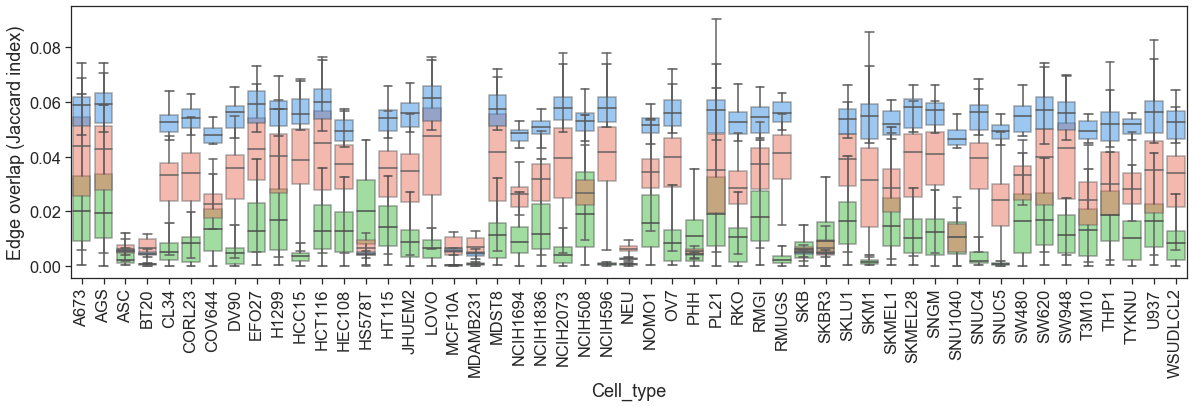

In [95]:
fig = plt.figure()
fig.set_size_inches(20, 5)
sns.set(font_scale=1.5)
with sns.axes_style("ticks"):
    sns.boxplot(QUIZC_allcells['Cell_type'], 
                [list(QUIZC_edge_overlap_df.loc[c][set(QUIZC_allcells['Cell_type']) - set([c])].values.astype(float)) for c in QUIZC_allcells['Cell_type']],
               color='limegreen', showfliers=False, boxprops=dict(alpha=.5))
    sns.boxplot(MODZ_allcells['Cell_type'], 
                [list(MODZ_edge_overlap_df.loc[c][set(MODZ_allcells['Cell_type']) - set([c])].values.astype(float)) for c in MODZ_allcells['Cell_type']],
               color='tomato', showfliers=False, boxprops=dict(alpha=.5))
    sns.boxplot(CD_allcells['Cell_type'], 
                [list(CD_edge_overlap_df.loc[c][set(CD_allcells['Cell_type']) - set([c])].values.astype(float)) for c in CD_allcells['Cell_type']],
               color='dodgerblue', showfliers=False, boxprops=dict(alpha=.5))
    plt.xticks(rotation=90)
    plt.ylabel('Edge overlap (Jaccard index)')
    plt.savefig(proj_output_path + 'edge_overlap_all_boxplot_nofliers.pdf', format='pdf')
    plt.show()

## Network densities for QUIZ-C/MODZ/CD (Supplementary Figure 4D)

In [86]:
f = open(proj_output_path + 'QUIZC_network_stats.csv', 'w')
f.write('Cell_type,N_drugs,N_targets,M,Density\n')
for c in sorted(list(QUIZC_nodelist_df_dict.keys())):
    f.write('%s,%s,%s,%s,%s\n' % (c, 
                                  len(set(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Drug']['Id'])),
                                  len(set(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Gene']['Id'])), 
                                  len(QUIZC_edgelist_df_dict[c]), 
                                  len(QUIZC_edgelist_df_dict[c])/(len(set(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Drug']['Id']))*
                                                            len(set(QUIZC_nodelist_df_dict[c][QUIZC_nodelist_df_dict[c]['Type']=='Gene']['Id'])))))
f.close()

f = open(proj_output_path + 'MODZ_network_stats.csv', 'w')
f.write('Cell_type,N_drugs,N_targets,M,Density\n')
for c in sorted(list(MODZ_nodelist_df_dict.keys())):
    f.write('%s,%s,%s,%s,%s\n' % (c, 
                                  len(set(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Drug']['Id'])),
                                  len(set(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Gene']['Id'])), 
                                  len(MODZ_edgelist_df_dict[c]), 
                                  len(MODZ_edgelist_df_dict[c])/(len(set(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Drug']['Id']))*
                                                            len(set(MODZ_nodelist_df_dict[c][MODZ_nodelist_df_dict[c]['Type']=='Gene']['Id'])))))
f.close()

f = open(proj_output_path + 'CD_network_stats.csv', 'w')
f.write('Cell_type,N_drugs,N_targets,M,Density\n')
for c in sorted(list(CD_nodelist_df_dict.keys())):
    f.write('%s,%s,%s,%s,%s\n' % (c, 
                                  len(set(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Drug']['Id'])),
                                  len(set(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Gene']['Id'])), 
                                  len(CD_edgelist_df_dict[c]), 
                                  len(CD_edgelist_df_dict[c])/(len(set(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Drug']['Id']))*
                                                            len(set(CD_nodelist_df_dict[c][CD_nodelist_df_dict[c]['Type']=='Gene']['Id'])))))
f.close()

In [89]:
QUIZC_net_stats = pd.read_csv(proj_output_path + 'QUIZC_network_stats.csv')
MODZ_net_stats = pd.read_csv(proj_output_path + 'MODZ_network_stats.csv')
CD_net_stats = pd.read_csv(proj_output_path + 'CD_network_stats.csv')

QUIZC_net_stats.columns = [x + '_QUIZC' for x in QUIZC_net_stats.columns]
MODZ_net_stats.columns = [x + '_MODZ' for x in MODZ_net_stats.columns]
CD_net_stats.columns = [x + '_CD' for x in CD_net_stats.columns]

In [91]:
merged_net_stats = pd.merge(QUIZC_net_stats, pd.merge(MODZ_net_stats, CD_net_stats, how='outer', left_on='Cell_type_MODZ', right_on='Cell_type_CD'), 
         how='outer', left_on='Cell_type_QUIZC', right_on='Cell_type_MODZ')

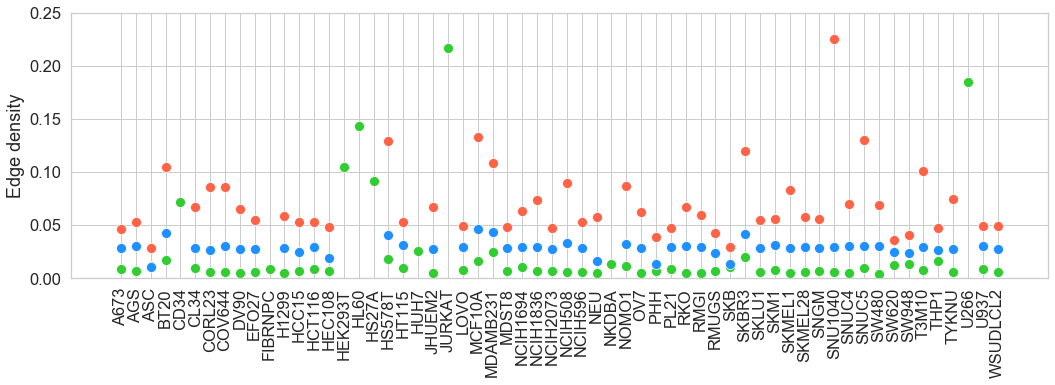

In [92]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.scatterplot(x='Cell_type_QUIZC', y='Density_QUIZC', data=merged_net_stats, color='limegreen', s=100)
    sns.scatterplot(x='Cell_type_QUIZC', y='Density_MODZ', data=merged_net_stats, color='tomato', s=100)
    sns.scatterplot(x='Cell_type_QUIZC', y='Density_CD', data=merged_net_stats,  color='dodgerblue', s=100)
    plt.xticks(rotation=90)
    plt.ylim(0, 0.25)
    plt.tight_layout()
    plt.ylabel('Edge density')
    plt.xlabel('')
    plt.savefig(proj_output_path + 'Edge_densities.pdf', format='pdf')
    plt.show()

## Edge direction concordance (Figure 4E)

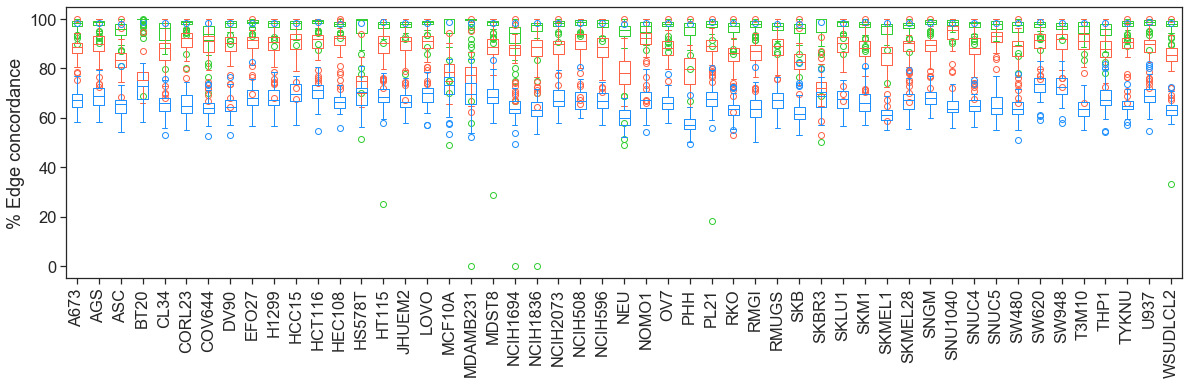

In [96]:
fig = plt.figure()
fig.set_size_inches(20, 5)
sns.set(font_scale=1.5)
with sns.axes_style("ticks"):
    box1 = plt.boxplot([list(QUIZC_edge_concordance_df[c][~pd.isnull(QUIZC_edge_concordance_df[c])].values) for c in MODZ_allcells['Cell_type']])
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color='limegreen')
    plt.setp(box1["fliers"], markeredgecolor='limegreen')    
    
    box2 = plt.boxplot([list(MODZ_edge_concordance_df[c][~pd.isnull(MODZ_edge_concordance_df[c])].values) for c in MODZ_allcells['Cell_type']])
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color='tomato')
    plt.setp(box2["fliers"], markeredgecolor='tomato')  
    
    box3 = plt.boxplot([list(CD_edge_concordance_df[c][~pd.isnull(CD_edge_concordance_df[c])].values) for c in MODZ_allcells['Cell_type']])
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color='dodgerblue')
    plt.setp(box3["fliers"], markeredgecolor='dodgerblue') 
    
    plt.xticks(np.arange(1, len(MODZ_allcells['Cell_type'])+1),  MODZ_allcells['Cell_type'].values)
    plt.xticks(rotation=90)
    plt.ylabel('% Edge concordance')
    plt.savefig(proj_output_path + 'edge_concordance_all_boxplot_NEW.pdf', format='pdf')
    plt.show()

## Reducibility analysis (Figure 2E, Supp. Fig. 5)

In [1086]:
### Write edges to file with integer IDs
# for c in allcells['Cell_type']:   
#     pd.merge(pd.merge(edgelist_df_dict[c], allnodes, left_on='Drug', right_on='Node_name'), allnodes, left_on='Target', 
#              right_on='Node_name')[['Node_ID_x', 'Node_ID_y']].to_csv('/Users/ardahalu/Desktop/QUIZC75_reducibility_edgelists/%s_edgelist.txt' % c, 
#                                                                       index=False, header=None, sep=' ')

In [97]:
from matplotlib.colors import rgb2hex, colorConverter
from collections import defaultdict

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

# (http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python) and (https://nbviewer.jupyter.org/gist/vals/150ec97a5b7db9c82ee9) 
# Note: This is an ingenious method but has one minor flaw -- if the upper and lower legs of two branches somehow coincide (in the reducibility 
# dendrogram it does, so I guess it's not that rare), the same coordinate can be registered as a leaf in two different classes, and when the time 
# comes to plot, the non-leaf color can override the actual leaf color. to circumvent this issue, we should either remove whichever labels are 
# duplicated from the non-leaf (grey in this case) color, or make the coloring order such that grey gets colored first and all other colors 
# overwrite it.
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            #print(c, '|', pi, '|', leg,'|', i, '|', abs(i - int(i)) < 1e-5)
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    # not the best solution but here is where we remove the redundant key from the grey class(i.e. "above_color_threshold parameter", set to #AAAAAA) 
    for key in set(cluster_idxs.keys()) - set(['#AAAAAA']):
        overlap = set(cluster_idxs[key]) & set(cluster_idxs['#AAAAAA'])
        #print(key, overlap, len(overlap))
        if len(overlap) > 0:
            for o in overlap:
                cluster_idxs['#AAAAAA'].pop(np.where(np.array(cluster_idxs['#AAAAAA'])==o)[0][0])                
                
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

In [102]:
temp_cmap = get_cmap('gist_rainbow', 20) 
temp_cmap_hex = [rgb2hex(temp_cmap(i)[:3]) for i in range(temp_cmap.N)]
temp_palette = random.sample(temp_cmap_hex, len(temp_cmap_hex))
set_link_color_palette(temp_palette)

In [103]:
MODZ_multired_Z = np.load(proj_input_path + 'MODZ_reducibility_edgelists/Z.npy')
MODZ_multired_q_vals = np.load(proj_input_path + 'MODZ_reducibility_edgelists/q_vals.npy')
MODZ_multired_cuts = list(np.load(proj_input_path + 'MODZ_reducibility_edgelists/cuts.npy', allow_pickle=True))
MODZ_multired_JSD_matrix = np.load(proj_input_path + 'MODZ_reducibility_edgelists/JSD_matrix.npy')

CD_multired_Z = np.load(proj_input_path + 'CD_reducibility_edgelists/Z.npy')
CD_multired_q_vals = np.load(proj_input_path + 'CD_reducibility_edgelists/q_vals.npy')
CD_multired_cuts = list(np.load(proj_input_path + 'CD_reducibility_edgelists/cuts.npy', allow_pickle=True))
CD_multired_JSD_matrix = np.load(proj_input_path + 'CD_reducibility_edgelists/JSD_matrix.npy')

QUIZC_multired_Z = np.load(proj_input_path + 'QUIZC_common51cells_reducibility_edgelists/Z.npy')
QUIZC_multired_q_vals = np.load(proj_input_path + 'QUIZC_common51cells_reducibility_edgelists/q_vals.npy')
QUIZC_multired_cuts = list(np.load(proj_input_path + 'QUIZC_common51cells_reducibility_edgelists/cuts.npy', allow_pickle=True))
QUIZC_multired_JSD_matrix = np.load(proj_input_path + 'QUIZC_common51cells_reducibility_edgelists/JSD_matrix.npy')

In [104]:
QUIZC_multired_JSD_df = pd.DataFrame(QUIZC_multired_JSD_matrix, index=MODZ_allcells['Cell_type'], columns=MODZ_allcells['Cell_type'])
MODZ_multired_JSD_df = pd.DataFrame(MODZ_multired_JSD_matrix, index=MODZ_allcells['Cell_type'], columns=MODZ_allcells['Cell_type'])
CD_multired_JSD_df = pd.DataFrame(CD_multired_JSD_matrix, index=MODZ_allcells['Cell_type'], columns=MODZ_allcells['Cell_type'])

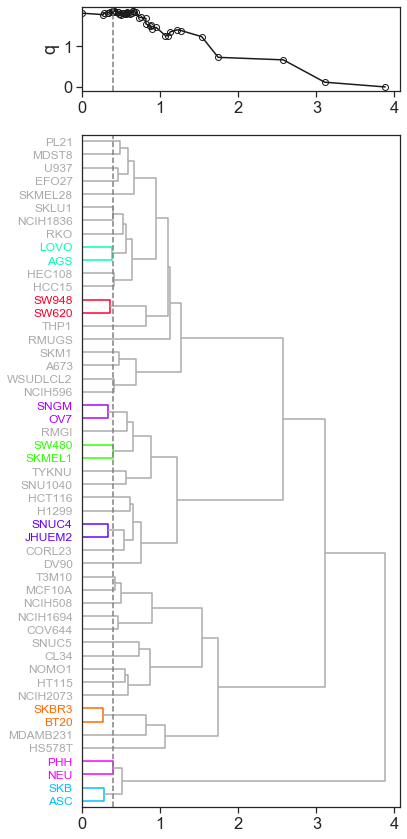

In [107]:
fig = plt.figure()
fig.set_size_inches(6, 12)
sns.set(font_scale=1.5)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 8]) 

threshold = np.insert(QUIZC_multired_Z[:, 2], 0 , 0)[np.argmax(np.abs(QUIZC_multired_q_vals))]
with sns.axes_style("ticks"):
    ax1 = plt.subplot(gs[0])
    plt.plot(np.insert(QUIZC_multired_Z[:, 2], 0 , 0), np.abs(QUIZC_multired_q_vals), '-o', color='k', mfc='none')
    ax1.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    plt.ylabel('q')

    # share x and y
    ax2 = plt.subplot(gs[1], sharex=ax1)
    dendro = dendrogram(QUIZC_multired_Z, orientation='right', color_threshold=threshold, above_threshold_color='#AAAAAA', 
                       labels=list(CD_allcells['Cell_type']) ) #cell labels left as CD since the cell line list of QUIZC is the same as CD and LCB
    ax2.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    ax2.tick_params(axis='y', which='major', labelsize=12)
    
    
    ylbls = ax2.get_ymajorticklabels()
    
    cluster_classes = get_cluster_classes(dendro)
    col_list = []
    for ci in dendro['ivl']:
        for col, c in cluster_classes.items():
            if ci in c:
                col_list.append(col)
                
    for ix, lbl in enumerate(ylbls):
        lbl.set_color(col_list[ix])
    
    #plt.xlim(0.01, 5.0)
    plt.tight_layout()
    plt.savefig(proj_output_path + 'QUIZC_reducibility.pdf', format='pdf', bbox_inches='tight')
    plt.show()

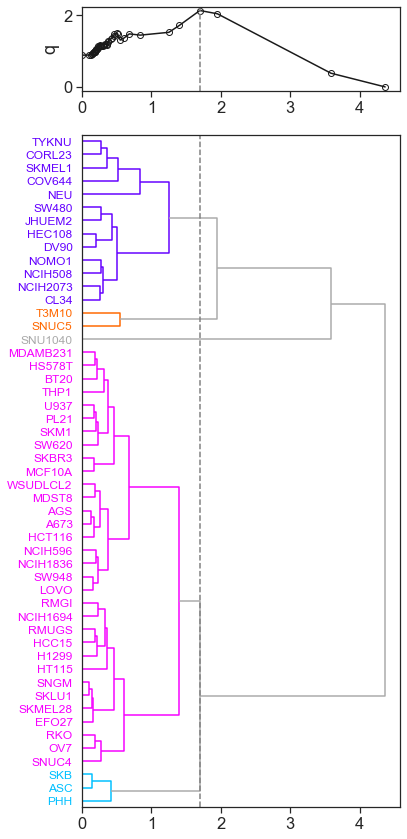

In [108]:
fig = plt.figure()
fig.set_size_inches(6, 12)
sns.set(font_scale=1.5)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 8]) 

threshold = np.insert(MODZ_multired_Z[:, 2], 0 , 0)[np.argmax(np.abs(MODZ_multired_q_vals))]
with sns.axes_style("ticks"):
    ax1 = plt.subplot(gs[0])
    plt.plot(np.insert(MODZ_multired_Z[:, 2], 0 , 0), np.abs(MODZ_multired_q_vals), '-o', color='k', mfc='none')
    ax1.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    plt.ylabel('q')

    # share x and y
    ax2 = plt.subplot(gs[1], sharex=ax1)
    dendro = dendrogram(MODZ_multired_Z, orientation='right', color_threshold=threshold, above_threshold_color='#AAAAAA', 
                       labels=list(MODZ_allcells['Cell_type']) )  
    ax2.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    ax2.tick_params(axis='y', which='major', labelsize=12)
    
    
    ylbls = ax2.get_ymajorticklabels()
    
    cluster_classes = get_cluster_classes(dendro)
    col_list = []
    for ci in dendro['ivl']:
        for col, c in cluster_classes.items():
            if ci in c:
                col_list.append(col)
                
    for ix, lbl in enumerate(ylbls):
        lbl.set_color(col_list[ix])
    
    #plt.xlim(0.01, 5.0)
    plt.tight_layout()
    plt.savefig(proj_output_path + 'MODZ_reducibility.pdf', format='pdf', bbox_inches='tight')
    plt.show()

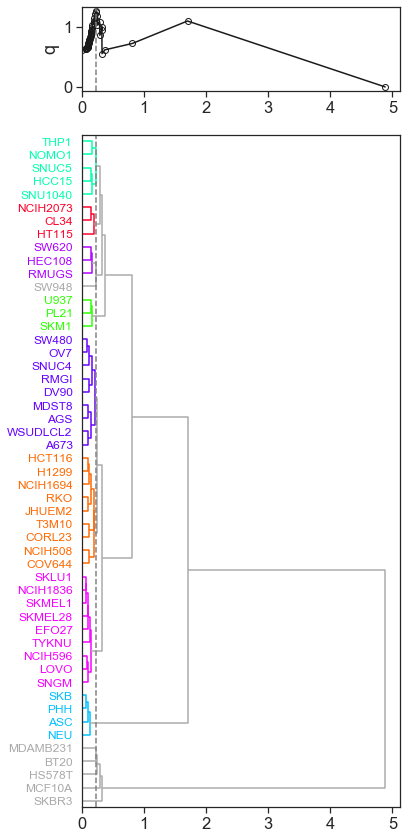

In [109]:
fig = plt.figure()
fig.set_size_inches(6, 12)
sns.set(font_scale=1.5)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 8]) 

threshold = np.insert(CD_multired_Z[:, 2], 0 , 0)[np.argmax(np.abs(CD_multired_q_vals))]
with sns.axes_style("ticks"):
    ax1 = plt.subplot(gs[0])
    plt.plot(np.insert(CD_multired_Z[:, 2], 0 , 0), np.abs(CD_multired_q_vals), '-o', color='k', mfc='none')
    ax1.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    plt.ylabel('q')

    # share x and y
    ax2 = plt.subplot(gs[1], sharex=ax1)
    dendro = dendrogram(CD_multired_Z, orientation='right', color_threshold=threshold, above_threshold_color='#AAAAAA', 
                       labels=list(CD_allcells['Cell_type']) )  
    ax2.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    ax2.tick_params(axis='y', which='major', labelsize=12)
    
    
    ylbls = ax2.get_ymajorticklabels()
    
    cluster_classes = get_cluster_classes(dendro)
    col_list = []
    for ci in dendro['ivl']:
        for col, c in cluster_classes.items():
            if ci in c:
                col_list.append(col)
                
    for ix, lbl in enumerate(ylbls):
        lbl.set_color(col_list[ix])
    
    #plt.xlim(0.01, 5.0)
    plt.tight_layout()
    plt.savefig(proj_output_path + 'CD_reducibility.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [110]:
(51 - 43) / 50.0, (51 - 5) / 50.0, (51 - 14) / 50.0

(0.16, 0.92, 0.74)

### Single Tandem Repeat (STR) profile similarity of cell lines (Supplementary Figure 6)
Using Cellosaurus data + CLASTR (STR profile similarity)

In [133]:
cs = pd.read_csv(proj_input_path + 'cellosaurus.txt', sep='   ', skiprows=55, engine='python', header=None)

cs_L1000cells_df_dict = {}
for c in tqdm(QUIZC_allcells['Cell_type']):
    temp_ID_df = cs[(cs[0] == 'ID') & (cs[1].str.contains(c))]
    temp_SY_df = cs[(cs[0] == 'SY') & (cs[1].str.contains(c))]    
    cs_L1000cells_df_dict[c] = pd.concat([temp_ID_df, temp_SY_df])

# corner case: add RMG-I, whose synonym is RMG1 and not RMGI
cs_L1000cells_df_dict['RMGI'] = cs[(cs[0] == 'ID') & (cs[1].str.contains('RMG-I'))]

# corner case: since the main OV7 (ID) with the ST values is overwritten by the synonym version without ST values, we need to remove those
cs_L1000cells_df_dict['OV7'] = cs_L1000cells_df_dict['OV7'].iloc[:-1]

cs_L1000cells_df_full_dict = {}
for c in QUIZC_allcells['Cell_type']:
    cs_L1000cells_df_full_dict[c] = {}
    
for c in tqdm(QUIZC_allcells['Cell_type']):
    
    for n, ix in enumerate(cs_L1000cells_df_dict[c].index.values):

        left_cut = np.min(np.abs(ix - cs[cs[0]=='//'].index.values))
        left_index = ix - left_cut
        right_index = cs[cs[0]=='//'].index.values[np.where(cs[cs[0]=='//'].index.values==left_index)[0][0] + 1]
        
        cs_L1000cells_df_full_dict[c][cs.iloc[ix][1]] = cs.iloc[left_index:right_index]

cs_ST_df_dict = {}
for c in QUIZC_allcells['Cell_type']:
    cs_ST_df_dict[c] = {}
for c in QUIZC_allcells['Cell_type']:
    for key in cs_L1000cells_df_full_dict[c].keys():
        if 'ST' in set(cs_L1000cells_df_full_dict[c][key][0]):
            #print(c, '|', key, '|', 'data available')
            cs_ST_df_dict[c][key] = pd.DataFrame(np.array(list(cs_L1000cells_df_full_dict[c][key][cs_L1000cells_df_full_dict[c][key][0]=='ST'][1]
                                                               .str.split(': ').values)))

ST_all_keys = []
for c in QUIZC_allcells['Cell_type']:
    ST_all_keys.extend(list(cs_ST_df_dict[c].keys()))
ST_all_keys = set(ST_all_keys)

CLASTR_df = pd.DataFrame(columns=ST_all_keys, index=['Amelogenin', 'CSF1PO', 'D2S1338', 'D3S1358', 'D5S818', 'D7S820', 'D8S1179', 
                                                               'D13S317', 'D16S539', 'D18S51', 'D19S433', 'D21S11', 'FGA', 'Penta D', 'Penta E', 
                                                               'TH01', 'TPOX', 'vWA'])

for c in QUIZC_allcells['Cell_type']:
    for key in cs_ST_df_dict[c].keys():        
        temp_ST_df = cs_ST_df_dict[c][key].iloc[1:]
        for s, t in temp_ST_df[[0, 1]].values:
            CLASTR_df.at[s, key] = t
            
for c in QUIZC_allcells['Cell_type']:
    for key in cs_ST_df_dict[c].keys():        
        temp_ST_df = cs_ST_df_dict[c][key].iloc[1:]
        for s, t in temp_ST_df[[0, 1]].values:
            CLASTR_df.at[s, key] = t

CLASTR_df.T.to_csv(proj_output_path + 'L1000_CLASTR_query.csv', index=True)

# get the Cellosaurus accession numbers (AC IDs) for 52 selected cell lines for which we have calculated the CLASTR STR similarity scores
cs_AC_df_dict = {}
for c in QUIZC_allcells['Cell_type']:
    for key in cs_L1000cells_df_full_dict[c].keys():
        cs_AC_df_dict[key] = cs_L1000cells_df_full_dict[c][key][cs_L1000cells_df_full_dict[c][key][0]=='AC'][1].values[0]
cs_AC_df = pd.DataFrame.from_dict(cs_AC_df_dict, orient='Index').rename(columns={0: 'AC'})

CLASTR_selected_rows = pd.read_csv(proj_input_path + 'L1000_CLASTR_query_selected_rows.csv')
CLASTR_selected_ACs = pd.merge(cs_AC_df, CLASTR_selected_rows, left_index=True, right_on='Cellosaurus ID/Synonym').set_index('L1000 ID')

CLASTR_54_sim_df = pd.DataFrame(index=CLASTR_selected_ACs.index, columns=CLASTR_selected_ACs.index)

# cell lines missing STR profile information: CD34, FIBRNPC, MCH58, NEU, NKDBA, PHH, SKB, 
print(set(QUIZC_allcells['Cell_type']) - set(CLASTR_54_sim_df.index))

clastr_path = proj_input_path + 'CLASTR_results/'

CLASTR_results_df_dict = {}
for f in os.listdir(clastr_path):
    if f.endswith('CLASTR_Results.csv'):
        CLASTR_results_df_dict[f.split('_')[0]] = pd.read_csv(clastr_path + f).iloc[1:]

for i in CLASTR_selected_ACs.index:
    for j in CLASTR_selected_ACs.index:
        if len(CLASTR_results_df_dict[i][CLASTR_results_df_dict[i]['Accession']
                                                            .str.contains(CLASTR_selected_ACs.loc[j]['AC'])]) > 0:
            CLASTR_54_sim_df.at[i, j] = CLASTR_results_df_dict[i][CLASTR_results_df_dict[i]['Accession']
                                                            .str.contains(CLASTR_selected_ACs.loc[j]['AC'])]['Score'].values[0].replace('%', '')
        else:
            CLASTR_54_sim_df.at[i, j] = 0.0

CLASTR_54_sim_df = CLASTR_54_sim_df.astype(float)

for i in CLASTR_54_sim_df.index:
    for j in CLASTR_54_sim_df.index:
        if CLASTR_54_sim_df.at[i, j] != CLASTR_54_sim_df.at[j, i]:
            CLASTR_54_sim_df.at[i, j] = max(CLASTR_54_sim_df.at[i, j], CLASTR_54_sim_df.at[j, i])
            CLASTR_54_sim_df.at[j, i] = CLASTR_54_sim_df.at[i, j]

CLASTR_54_sim_df.to_csv(proj_output_path + 'CLASTR_54_sim_df.csv')

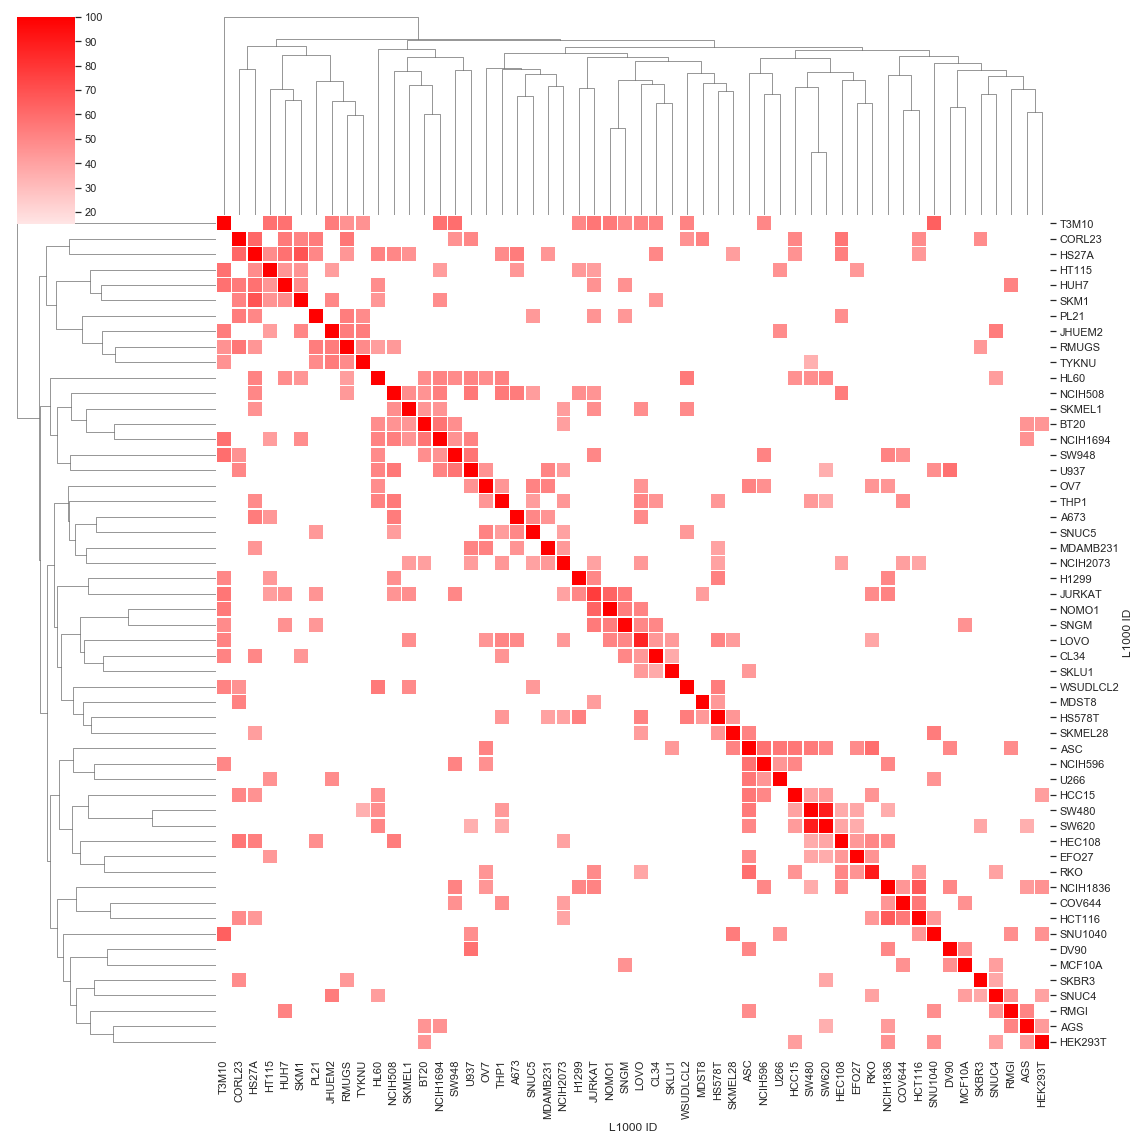

In [134]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

sns.set(font_scale=1.0)
with sns.axes_style("white"):
    sns.clustermap(CLASTR_54_sim_df, mask=CLASTR_54_sim_df==0, cmap=sns.light_palette('red', n_colors=20, as_cmap=True), linewidths=0.5, 
                   figsize=(16, 16), vmin=15, vmax=100)
    plt.savefig(proj_output_path + 'STR_similarity_clustered.pdf', format='pdf', bbox_inches='tight')

In [135]:
# percent under detection threshold (not within top-1000 similar) 
below_ths_df = pd.DataFrame(index=sorted(list(CLASTR_results_df_dict.keys())), columns=['# cell lines with similarity score below threshold', 
                                                                          '% cell lines with similarity score below threshold', 
                                                                          'Score threshold for top 1000'])
for c in CLASTR_results_df_dict.keys():
    
    below_ths_df.at[c, '# cell lines with similarity score below threshold'] = len(CLASTR_54_sim_df[c][CLASTR_54_sim_df[c]==0.0])
    below_ths_df.at[c, '% cell lines with similarity score below threshold'] = 100.0 * len(CLASTR_54_sim_df[c][CLASTR_54_sim_df[c]==0.0]) /\
                                                                        len(CLASTR_54_sim_df)    
    below_ths_df.at[c, 'Score threshold for top 1000'] = np.min(CLASTR_results_df_dict[c]['Score'].str.replace('%', '').astype(float))

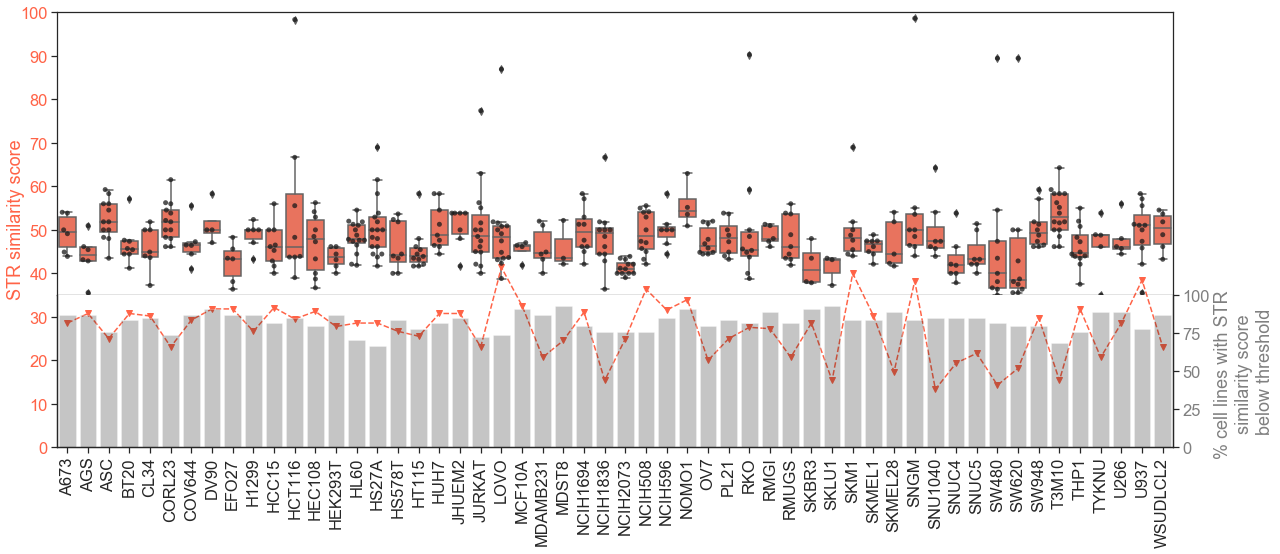

In [136]:
fig = plt.figure()
fig.set_size_inches(20, 8)
sns.set(font_scale=1.5)
gs = gridspec.GridSpec(2, 1, height_ratios=[6.5, 3.5]) 
gs.update(wspace=0.025, hspace=0)

with sns.axes_style("ticks"):
    ax1 = plt.subplot(gs[0])
    sns.boxplot(data=CLASTR_54_sim_df[(CLASTR_54_sim_df>0) & (CLASTR_54_sim_df<100)], color='tomato')
    sns.swarmplot(data=CLASTR_54_sim_df[(CLASTR_54_sim_df>0) & (CLASTR_54_sim_df<100)], color='k', alpha=0.75)
    plt.plot(below_ths_df.index, below_ths_df['Score threshold for top 1000'], 'v--', color='tomato')
    #ax1.axvline(x=threshold, ymin=0.0, ymax=1.0, linestyle='--', color='grey')
    plt.xticks(rotation=90)
    plt.ylim(35, 100)
    ax1.tick_params(axis='y', labelcolor='tomato')
    
    ax2 = plt.subplot(gs[1], sharex=ax1)
    plt.plot(below_ths_df.index, below_ths_df['Score threshold for top 1000'], 'v--', color='tomato')
    plt.xticks(rotation=90)
    plt.ylim(0, 35)
    ax2.tick_params(axis='y', labelcolor='tomato')
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel('STR similarity score', y = 1.5)
    ax2.yaxis.label.set_color('tomato')
    
    # share x and y
    ax3 = ax2.twinx()
    sns.barplot(x=below_ths_df.index, y='% cell lines with similarity score below threshold', data=below_ths_df, orient='v', color='k', alpha=0.25)
    plt.xticks(rotation=90)
    plt.ylim(0, 100)
    ax3.tick_params(axis='y', labelcolor='grey')
    ax3.spines['top'].set_visible(False)
    ax3.set_ylabel('% cell lines with STR \nsimilarity score \nbelow threshold')
    ax3.yaxis.label.set_color('grey')
    
    plt.savefig(proj_output_path + 'STR_similarity.pdf', format='pdf', bbox_inches='tight')
    plt.show()

### Cell line ontology (CLO) analysis of the cell lines (Supplementary Figure 7)

#### Parse CLO data

In [137]:
clo_data = pd.read_csv(proj_input_path + 'CLO.csv', low_memory=False)

In [138]:
clo_edges = []
for i in tqdm(np.arange(len(clo_data))):
    if pd.isnull(clo_data.iloc[i]['Parents']) != True:
        for j in clo_data.iloc[i]['Parents'].split('|'):            
            temp_dict = {}
            temp_dict['Child']=clo_data.iloc[i]['Class ID'].split('/')[-1:][0]
            temp_dict['Parent']=j.split('/')[-1:][0]
            clo_edges.append(temp_dict)
clo_edges_df = pd.DataFrame(clo_edges)    

100%|██████████| 44874/44874 [00:34<00:00, 1284.54it/s]


In [139]:
clo_edges_df.to_csv(proj_output_path + 'CLO_edges.csv')

In [140]:
g_clo = nx.Graph()
g_clo.add_edges_from(clo_edges_df.values)

g_clo_dir = nx.DiGraph()
g_clo_dir.add_edges_from(clo_edges_df[['Parent', 'Child']].values)

In [141]:
len(g_clo.nodes()), len(g_clo.edges())

(44871, 46410)

In [142]:
nx.is_directed_acyclic_graph(g_clo), nx.is_directed_acyclic_graph(g_clo_dir)

(False, True)

In [143]:
clo_edges_df_CLOonly = clo_edges_df[(clo_edges_df['Child'].str.startswith('CLO_')) & (clo_edges_df['Parent'].str.startswith('CLO_'))]

In [144]:
g_clo_CLOonly = nx.Graph()
g_clo_CLOonly.add_edges_from(clo_edges_df_CLOonly.values)

g_clo_CLOonly_dir = nx.DiGraph()
g_clo_CLOonly_dir.add_edges_from(clo_edges_df_CLOonly[['Parent', 'Child']].values)

In [145]:
nx.is_directed_acyclic_graph(g_clo_CLOonly), nx.is_directed_acyclic_graph(g_clo_CLOonly_dir)

(False, True)

#### Calculate semantic similarity from CLO
Following [Wang, James Z., et al. "A new method to measure the semantic similarity of GO terms." Bioinformatics 23.10 (2007): 1274-1281](https://academic.oup.com/bioinformatics/article/23/10/1274/197095#1953560).

In [146]:
LINCS2CLO = pd.read_csv(proj_input_path + 'Cell_IDs_LINCS2CLO.csv')
LINCS2CLO = LINCS2CLO[~pd.isnull(LINCS2CLO['CLO ID'])]

In [147]:
w_s = 0.5

SV = {}
S_dict = {c: {} for c in LINCS2CLO['LINCS']}
    
for c in LINCS2CLO['LINCS']:
    
    clo_id = LINCS2CLO[LINCS2CLO['LINCS']==c]['CLO ID'].values[0]
    S_dict[c][clo_id] = 1.0
    
    anc = nx.ancestors(g_clo_dir, clo_id)
    anc.add(clo_id)
    dag = nx.subgraph(g_clo_dir, anc)
    for t in list(nx.dfs_postorder_nodes(dag, 'owl#Thing'))[1:]: # this has to go in order up the tree (owl#Thing is the top of the hierarchy)
        S_dict[c][t] = max([w_s * S_dict[c][t1] for t1 in list(dag.successors(t))])
    
    SV[c] = np.sum(list(S_dict[c].values()))

In [148]:
S_CLO_df = pd.DataFrame(index=LINCS2CLO['LINCS'], columns=LINCS2CLO['LINCS'])
for c1 in LINCS2CLO['LINCS']:
    for c2 in LINCS2CLO['LINCS']:        
        if len(set(S_dict[c1].keys()) & set(S_dict[c2].keys())) > 0:
            S_CLO_df.at[c1, c2] = np.sum([S_dict[c1][t] + S_dict[c2][t] for t in set(S_dict[c1].keys()) & set(S_dict[c2].keys())]) / (SV[c1] + SV[c2])
        else:
            S_CLO_df.at[c1, c2] = 0
S_CLO_df = S_CLO_df.astype(float)

In [149]:
S_CLO_df.to_csv(proj_output_path + 'CLO_sim_df.csv')

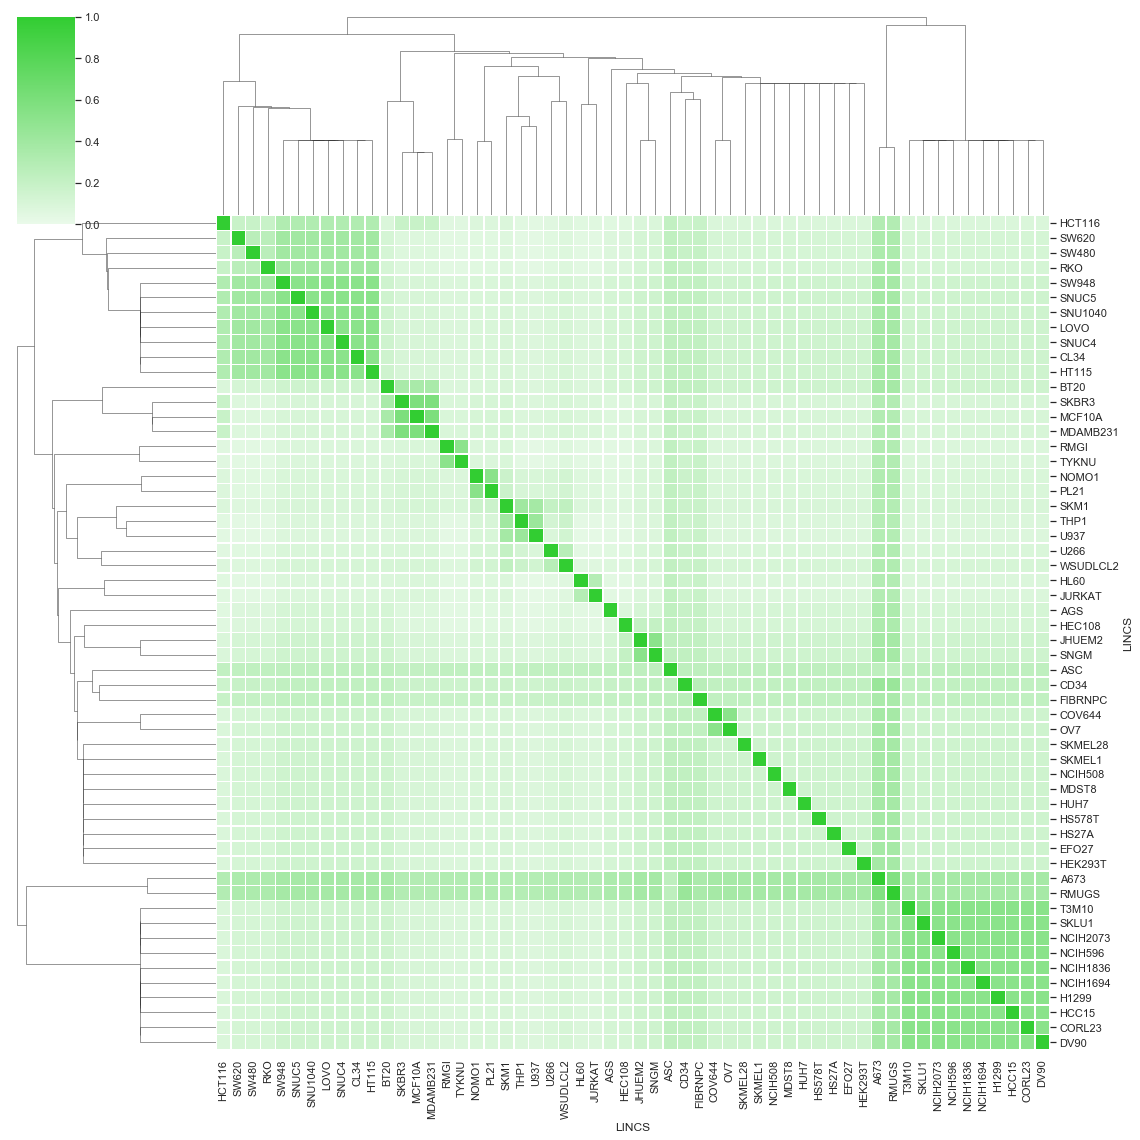

In [150]:
sns.set(font_scale=1.0)
with sns.axes_style("white"):
    sns.clustermap(S_CLO_df, cmap=sns.light_palette('limegreen', n_colors=20, as_cmap=True), linewidths=0.5, 
                   figsize=(16, 16), vmin=0.0, vmax=1.0)
    plt.savefig(proj_output_path + 'CLO_graph_based_semantic_similarity.pdf', format='pdf', bbox_inches='tight')

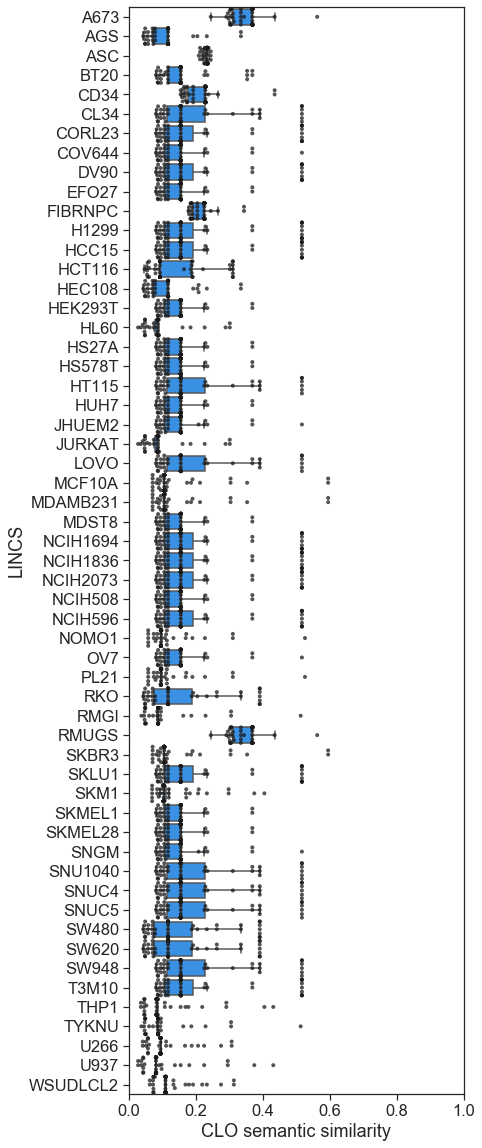

In [151]:
fig = plt.figure()
fig.set_size_inches(6, 20)
sns.set(font_scale=1.5)

with sns.axes_style("ticks"):

    ax1 = sns.boxplot(data=S_CLO_df[S_CLO_df<1.0], color='dodgerblue', orient='h',  showfliers = False)
    ax1 = sns.swarmplot(data=S_CLO_df[S_CLO_df<1.0], color='k', alpha=0.75, size=4, orient='h')
    plt.yticks(rotation=0)
    plt.xlim(0.0, 1.0)    
    plt.xlabel('CLO semantic similarity')
    plt.savefig(proj_output_path + 'L1000_CLO_semantic_similarity.pdf', format='pdf', bbox_inches='tight')
    plt.show()

### Enrichment of known drug-target interactions in QUIZC/MODZ/CD networks (Supp. Figs 8, 10A)                                                                         

#### Drug Repurposing Hub data
Each drug in DRH has MoA information so the % coverage in DRH also means % of drugs with known MoA. <br>
-About 60% of drugs on average had MoA information in the QUIZC networks. These numbers were similar to LCB and CD. This number indicates that 60% of the drugs have repurposing potential, while the rest are potentially novel drugs. <br> 
-We increase this coverage by using DGIdb in addition. <br>

In [152]:
DRH_samples = pd.read_csv(proj_input_path + 'repurposing_samples_20180907.txt', skiprows=9, sep='\t')
DRH_drugs = pd.read_csv(proj_input_path + 'repurposing_drugs_20180907.txt', skiprows=9, sep='\t')
print(len(DRH_drugs), len(DRH_samples))

6125 10147


In [153]:
DRH_drugs_samples_df = DRH_samples.join(DRH_drugs.set_index('pert_iname'), on='pert_iname')

In [158]:
DRH_coverage_df = pd.DataFrame(index=QUIZC_allcells['Cell_type'], columns=['DRH coverage (QUIZC)', 'DRH coverage (MODZ)', 'DRH coverage (CD)'])
for c in QUIZC_allcells['Cell_type']:
    DRH_coverage_df.at[c, 'DRH coverage (QUIZC)'] = 100.0 * (len(set(QUIZC_edgelist_df_dict[c]['Drug']) & set(DRH_drugs['pert_iname'])) / 
                                                          len(set(QUIZC_edgelist_df_dict[c]['Drug'])))
for c in MODZ_allcells['Cell_type']:
    DRH_coverage_df.at[c, 'DRH coverage (MODZ)'] = 100.0 * (len(set(MODZ_edgelist_df_dict[c]['Drug']) & set(DRH_drugs['pert_iname'])) /
                                                         len(set(MODZ_edgelist_df_dict[c]['Drug'])))
for c in CD_allcells['Cell_type']:
    DRH_coverage_df.at[c, 'DRH coverage (CD)'] = 100.0 * (len(set(CD_edgelist_df_dict[c]['Drug']) & set(DRH_drugs['pert_iname'])) /
                                                        len(set(CD_edgelist_df_dict[c]['Drug'])))

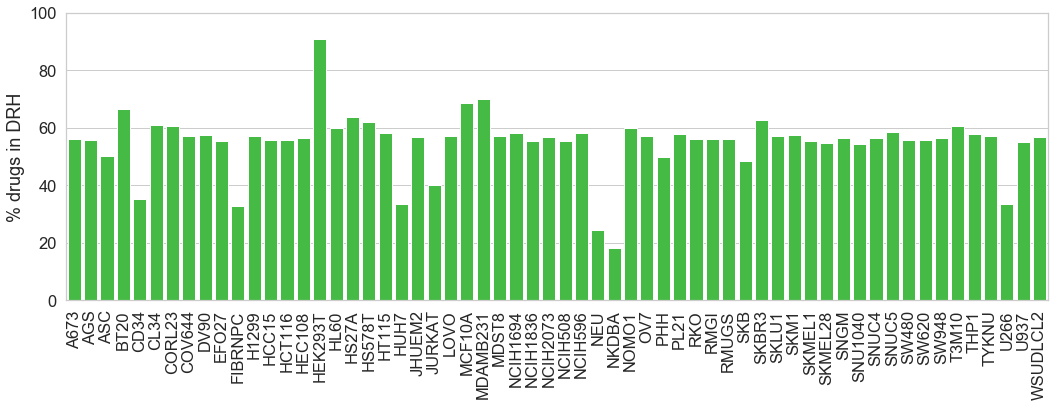

In [159]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.barplot(x=DRH_coverage_df.index, y='DRH coverage (QUIZC)', data=DRH_coverage_df, orient='v', color='limegreen')
    plt.ylim(0.0, 100.0)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('% drugs in DRH')
    plt.tight_layout()
    plt.savefig(proj_output_path + 'DRH_MoA_coverage_QUIZC.pdf', format='pdf', bbox_inches='tight')
    plt.show()

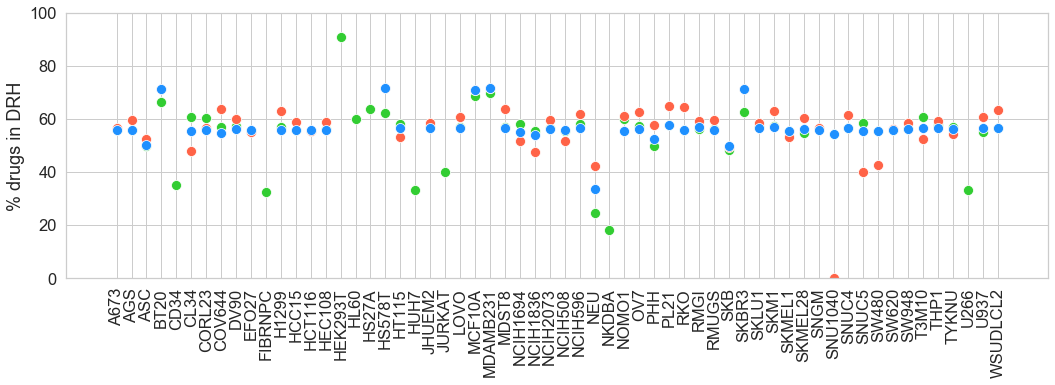

In [160]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.scatterplot(x=DRH_coverage_df.index, y='DRH coverage (QUIZC)', data=DRH_coverage_df, color='limegreen', s=100)
    sns.scatterplot(x=DRH_coverage_df.index, y='DRH coverage (MODZ)', data=DRH_coverage_df, color='tomato', s=100)
    sns.scatterplot(x=DRH_coverage_df.index, y='DRH coverage (CD)', data=DRH_coverage_df,  color='dodgerblue', s=100)
    plt.xticks(rotation=90)
    plt.ylim(0.0, 100.0)
    plt.tight_layout()
    plt.ylabel('% drugs in DRH')
    plt.xlabel('')
    plt.savefig(proj_output_path + 'DRH_MoA_coverage_all.pdf', format='pdf')
    plt.show()

In [161]:
# the drugs here are all unique i.e. one MoA per drug
DRH_drugs[DRH_drugs['pert_iname'].duplicated()]

,pert_iname,clinical_phase,moa,target,disease_area,indication


#### DGIdb data

In [163]:
DGIdb_interactions = pd.read_csv(proj_input_path +'interactions.tsv', sep='\t')
DGIdb_genes = pd.read_csv(proj_input_path +'genes.tsv', sep='\t')
DGIdb_drugs = pd.read_csv(proj_input_path +'drugs.tsv', sep='\t')
DGIdb_categories = pd.read_csv(proj_input_path +'categories.tsv', sep='\t')

In [542]:
# # write file to be sent to "https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi" for conversion between CHEMBL IDs and Pubchem CIDs
# f = open(proj_output_path + 'DGIdb_drug_CHEMBL_ids_Oct2020.txt', 'w')
# for i in list(set(DGIdb_drugs['chembl_id']))[1:]:
#     f.write('%s\n' % i)
# f.close()

In [164]:
DGIdb_CHEMBL2CID = pd.read_csv(proj_input_path + 'DGIdb_drug_CHEMBLids2CIDs.txt', sep='\t')
DGIdb_interactions_CID = pd.merge(DGIdb_interactions, DGIdb_CHEMBL2CID, left_on='drug_chembl_id', right_on='CHEMBL_id')

# L1000_pert_info = pd.read_csv('/Users/ardahalu/Research/CICS/L1000_project/L1000_data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t')
L1000_pert_info_cp = L1000_pert_info[L1000_pert_info['pert_type']=='trt_cp']
L1000_iname_CID_df = L1000_pert_info_cp[['pert_iname', 'pubchem_cid']]

# one 'pubchem cid' entry has characters in it, remove it manually 
L1000_iname_CID_df = L1000_iname_CID_df.loc[set(L1000_iname_CID_df.index) - set([20488])]
# convert the series to numeric
L1000_iname_CID_df['pubchem_cid'] = pd.to_numeric(L1000_iname_CID_df['pubchem_cid'])
# attach pert_iname values from L1000_pert_info to DGIdb data
DGIdb_interactions_iname_df = pd.merge(DGIdb_interactions_CID, L1000_iname_CID_df, left_on='CID', right_on='pubchem_cid')

In [166]:
DGIdb_coverage_df = pd.DataFrame(index=QUIZC_allcells['Cell_type'], columns=['DGIdb coverage (QUIZC)', 'DGIdb coverage (MODZ)', 'DGIdb coverage (CD)'])
for c in QUIZC_allcells['Cell_type']:
    DGIdb_coverage_df.at[c, 'DGIdb coverage (QUIZC)'] = 100.0 * (len(set(QUIZC_edgelist_df_dict[c]['Drug']) & 
                                                                    set(DGIdb_interactions_iname_df['pert_iname'])) / 
                                                          len(set(QUIZC_edgelist_df_dict[c]['Drug'])))
for c in MODZ_allcells['Cell_type']:
    DGIdb_coverage_df.at[c, 'DGIdb coverage (MODZ)'] = 100.0 * (len(set(MODZ_edgelist_df_dict[c]['Drug']) & 
                                                                   set(DGIdb_interactions_iname_df['pert_iname'])) /
                                                         len(set(MODZ_edgelist_df_dict[c]['Drug'])))
for c in CD_allcells['Cell_type']:
    DGIdb_coverage_df.at[c, 'DGIdb coverage (CD)'] = 100.0 * (len(set(CD_edgelist_df_dict[c]['Drug']) & 
                                                                  set(DGIdb_interactions_iname_df['pert_iname'])) /
                                                        len(set(CD_edgelist_df_dict[c]['Drug'])))

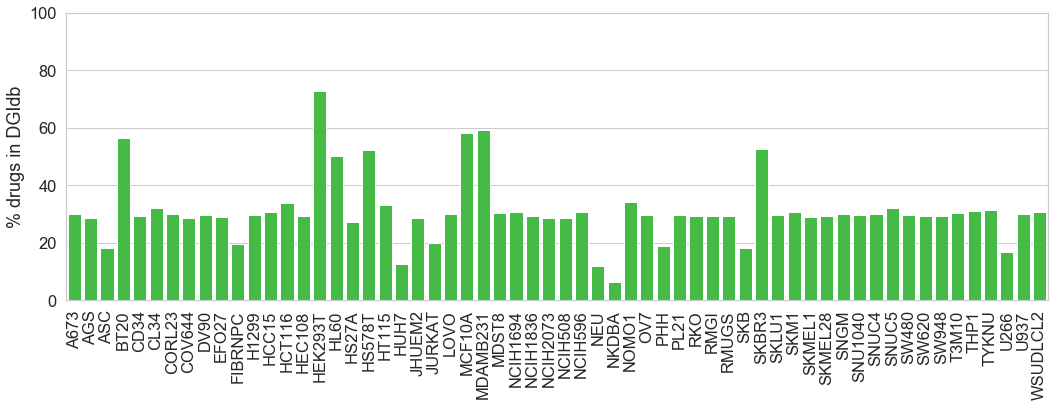

In [167]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.barplot(x=DGIdb_coverage_df.index, y='DGIdb coverage (QUIZC)', data=DGIdb_coverage_df, orient='v', color='limegreen')
    plt.ylim(0.0, 100.0)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('% drugs in DGIdb')
    plt.tight_layout()
    plt.savefig(proj_output_path + 'DGIdb_coverage_QUIZC.pdf', format='pdf', bbox_inches='tight')
    plt.show()

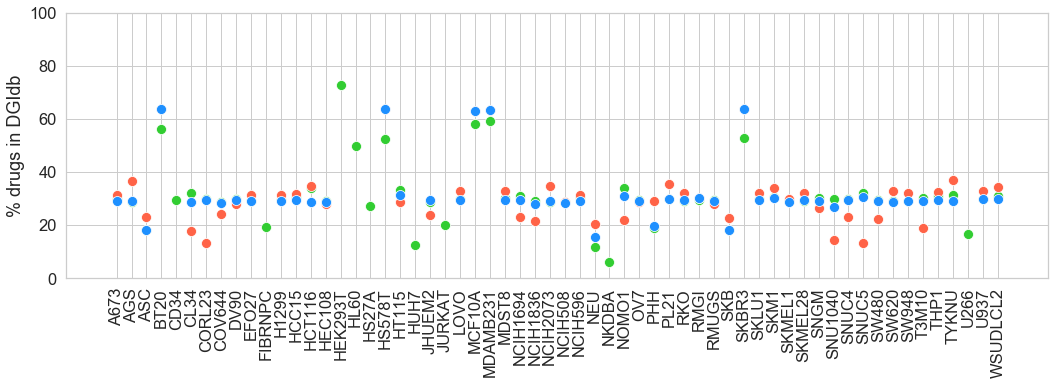

In [168]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.scatterplot(x=DGIdb_coverage_df.index, y='DGIdb coverage (QUIZC)', data=DGIdb_coverage_df, color='limegreen', s=100)
    sns.scatterplot(x=DGIdb_coverage_df.index, y='DGIdb coverage (MODZ)', data=DGIdb_coverage_df, color='tomato', s=100)
    sns.scatterplot(x=DGIdb_coverage_df.index, y='DGIdb coverage (CD)', data=DGIdb_coverage_df,  color='dodgerblue', s=100)
    plt.xticks(rotation=90)
    plt.ylim(0.0, 100.0)
    plt.tight_layout()
    plt.ylabel('% drugs in DGIdb')
    plt.xlabel('')
    plt.savefig(proj_output_path + 'DGIdb_coverage_all.pdf', format='pdf')
    plt.show()

#### DRH + DGIdb data

In [175]:
DRH_DGIdb_coverage_df = pd.DataFrame(index=QUIZC_allcells['Cell_type'], columns=['DRH+DGIdb coverage (QUIZC)', 'DRH+DGIdb coverage (MODZ)', 
                                                                           'DRH+DGIdb coverage (CD)'])
for c in QUIZC_allcells['Cell_type']:
    DRH_DGIdb_coverage_df.at[c, 'DRH+DGIdb coverage (QUIZC)'] = 100.0 * (len(set(QUIZC_edgelist_df_dict[c]['Drug']) & 
                                                                            (set(DGIdb_interactions_iname_df['pert_iname']) | 
                                                                             set(DRH_drugs['pert_iname']))) / 
                                                                        len(set(QUIZC_edgelist_df_dict[c]['Drug'])))
for c in MODZ_allcells['Cell_type']:
    DRH_DGIdb_coverage_df.at[c, 'DRH+DGIdb coverage (MODZ)'] = 100.0 * (len(set(MODZ_edgelist_df_dict[c]['Drug']) & 
                                                                            (set(DGIdb_interactions_iname_df['pert_iname']) | 
                                                                             set(DRH_drugs['pert_iname']))) /
                                                                       len(set(MODZ_edgelist_df_dict[c]['Drug'])))
for c in CD_allcells['Cell_type']:
    DRH_DGIdb_coverage_df.at[c, 'DRH+DGIdb coverage (CD)'] = 100.0 * (len(set(CD_edgelist_df_dict[c]['Drug']) &  
                                                                            (set(DGIdb_interactions_iname_df['pert_iname']) | 
                                                                             set(DRH_drugs['pert_iname']))) /
                                                                      len(set(CD_edgelist_df_dict[c]['Drug'])))

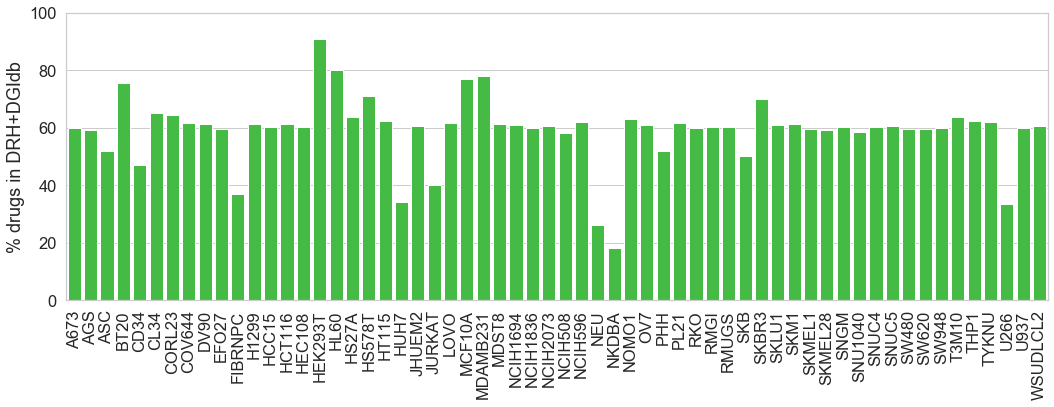

In [177]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.barplot(x=DRH_DGIdb_coverage_df.index, y='DRH+DGIdb coverage (QUIZC)', data=DRH_DGIdb_coverage_df, orient='v', color='limegreen')
    plt.ylim(0.0, 100.0)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('% drugs in DRH+DGIdb')
    plt.tight_layout()
    plt.savefig(proj_output_path + 'DRH_DGIdb_coverage_QUIZC.pdf', format='pdf', bbox_inches='tight')
    plt.show()

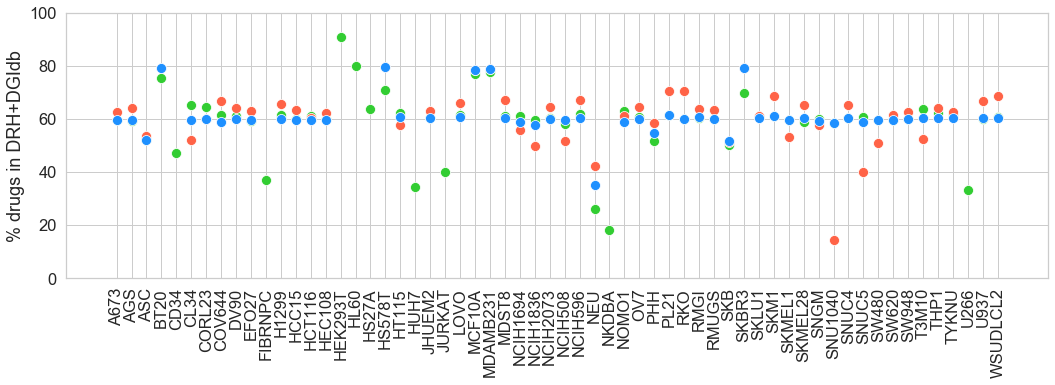

In [178]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.scatterplot(x=DRH_DGIdb_coverage_df.index, y='DRH+DGIdb coverage (QUIZC)', data=DRH_DGIdb_coverage_df, color='limegreen', s=100)
    sns.scatterplot(x=DRH_DGIdb_coverage_df.index, y='DRH+DGIdb coverage (MODZ)', data=DRH_DGIdb_coverage_df, color='tomato', s=100)
    sns.scatterplot(x=DRH_DGIdb_coverage_df.index, y='DRH+DGIdb coverage (CD)', data=DRH_DGIdb_coverage_df,  color='dodgerblue', s=100)
    plt.xticks(rotation=90)
    plt.ylim(0.0, 100.0)
    plt.tight_layout()
    plt.ylabel('% drugs in DRH+DGIdb')
    plt.xlabel('')
    plt.savefig(proj_output_path + 'DRH_DGIdb_coverage_all.pdf', format='pdf')
    plt.show()

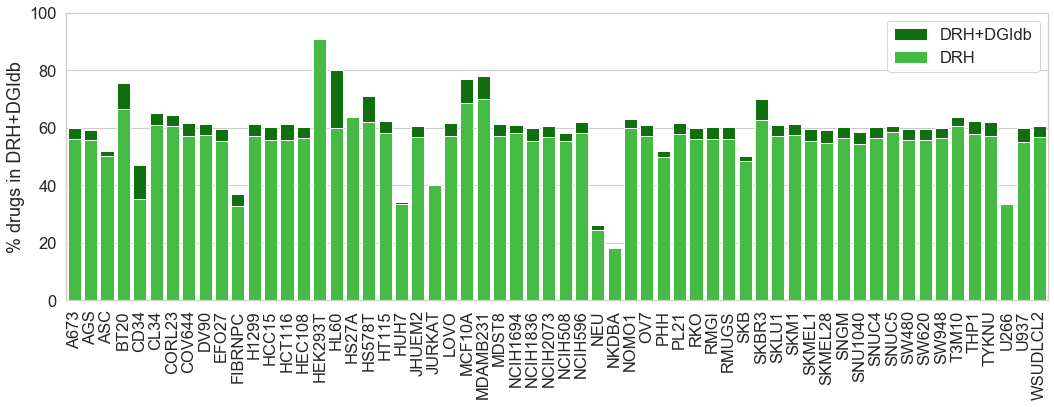

In [179]:
fig = plt.figure()
fig.set_size_inches(15, 6)
sns.set(font_scale=1.5)
with sns.axes_style('whitegrid'):
    sns.barplot(x=DRH_DGIdb_coverage_df.index, y='DRH+DGIdb coverage (QUIZC)', data=DRH_DGIdb_coverage_df, orient='v', color='green', 
                label='DRH+DGIdb')
    sns.barplot(x=DRH_coverage_df.index, y='DRH coverage (QUIZC)', data=DRH_coverage_df, orient='v', color='limegreen', label='DRH')
    plt.ylim(0.0, 100.0)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('% drugs in DRH+DGIdb')
    plt.legend()
    plt.tight_layout()
    plt.savefig(proj_output_path + 'DRH_DGIdb_coverage_QUIZC_ver2.pdf', format='pdf', bbox_inches='tight')
    plt.show()

### MoA and clinical phase breakdown of each cell type (Figure 3A, Supp. Fig. 9A-B)
In networks built using all three methods, we see a balanced representation of experimental drugs (drugs in the preclinical phase), investigational drugs (drugs in clinical development phases) and approved drugs. <br>

In [180]:
len(DRH_drugs['clinical_phase'].unique()), len(DRH_drugs['moa'].unique())

(8, 1355)

In [185]:
# make the dataframe indices in custom order so it goes from Preclinical to Launched instead of just alphabetically
QUIZC_clinical_phase_df = pd.DataFrame(0.0, index=['Preclinical', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 
                                             'Phase 3',  'Launched', 'Withdrawn'], columns= QUIZC_allcells['Cell_type'])
for c in QUIZC_allcells['Cell_type']:

    a = pd.merge(QUIZC_edgelist_df_dict[c]['Drug'], DRH_drugs, 
                 left_on='Drug', right_on='pert_iname').drop_duplicates('Drug').groupby('clinical_phase').size().sort_values(ascending=False)

    a_perc = a / a.sum() * 100.0
    
    for i in np.arange(len(a_perc)):
        QUIZC_clinical_phase_df.at[a_perc.index[i], c] = a_perc.values[i]
        

        
MODZ_clinical_phase_df = pd.DataFrame(0.0, index=['Preclinical', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 
                                             'Phase 3',  'Launched', 'Withdrawn'], columns= QUIZC_allcells['Cell_type'])
for c in MODZ_allcells['Cell_type']:

    a = pd.merge(MODZ_edgelist_df_dict[c]['Drug'], DRH_drugs, 
                 left_on='Drug', right_on='pert_iname').drop_duplicates('pert_iname').groupby('clinical_phase').size().sort_values(ascending=False)

    a_perc = a / a.sum() * 100.0
    
    for i in np.arange(len(a_perc)):
        MODZ_clinical_phase_df.at[a_perc.index[i], c] = a_perc.values[i]
        

CD_clinical_phase_df = pd.DataFrame(0.0, index=['Preclinical', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 
                                             'Phase 3',  'Launched', 'Withdrawn'], columns= QUIZC_allcells['Cell_type'])
for c in CD_allcells['Cell_type']:

    a = pd.merge(CD_edgelist_df_dict[c]['Drug'], DRH_drugs, 
                 left_on='Drug', right_on='pert_iname').drop_duplicates('pert_iname').groupby('clinical_phase').size().sort_values(ascending=False)

    a_perc = a / a.sum() * 100.0
    
    for i in np.arange(len(a_perc)):
        CD_clinical_phase_df.at[a_perc.index[i], c] = a_perc.values[i]

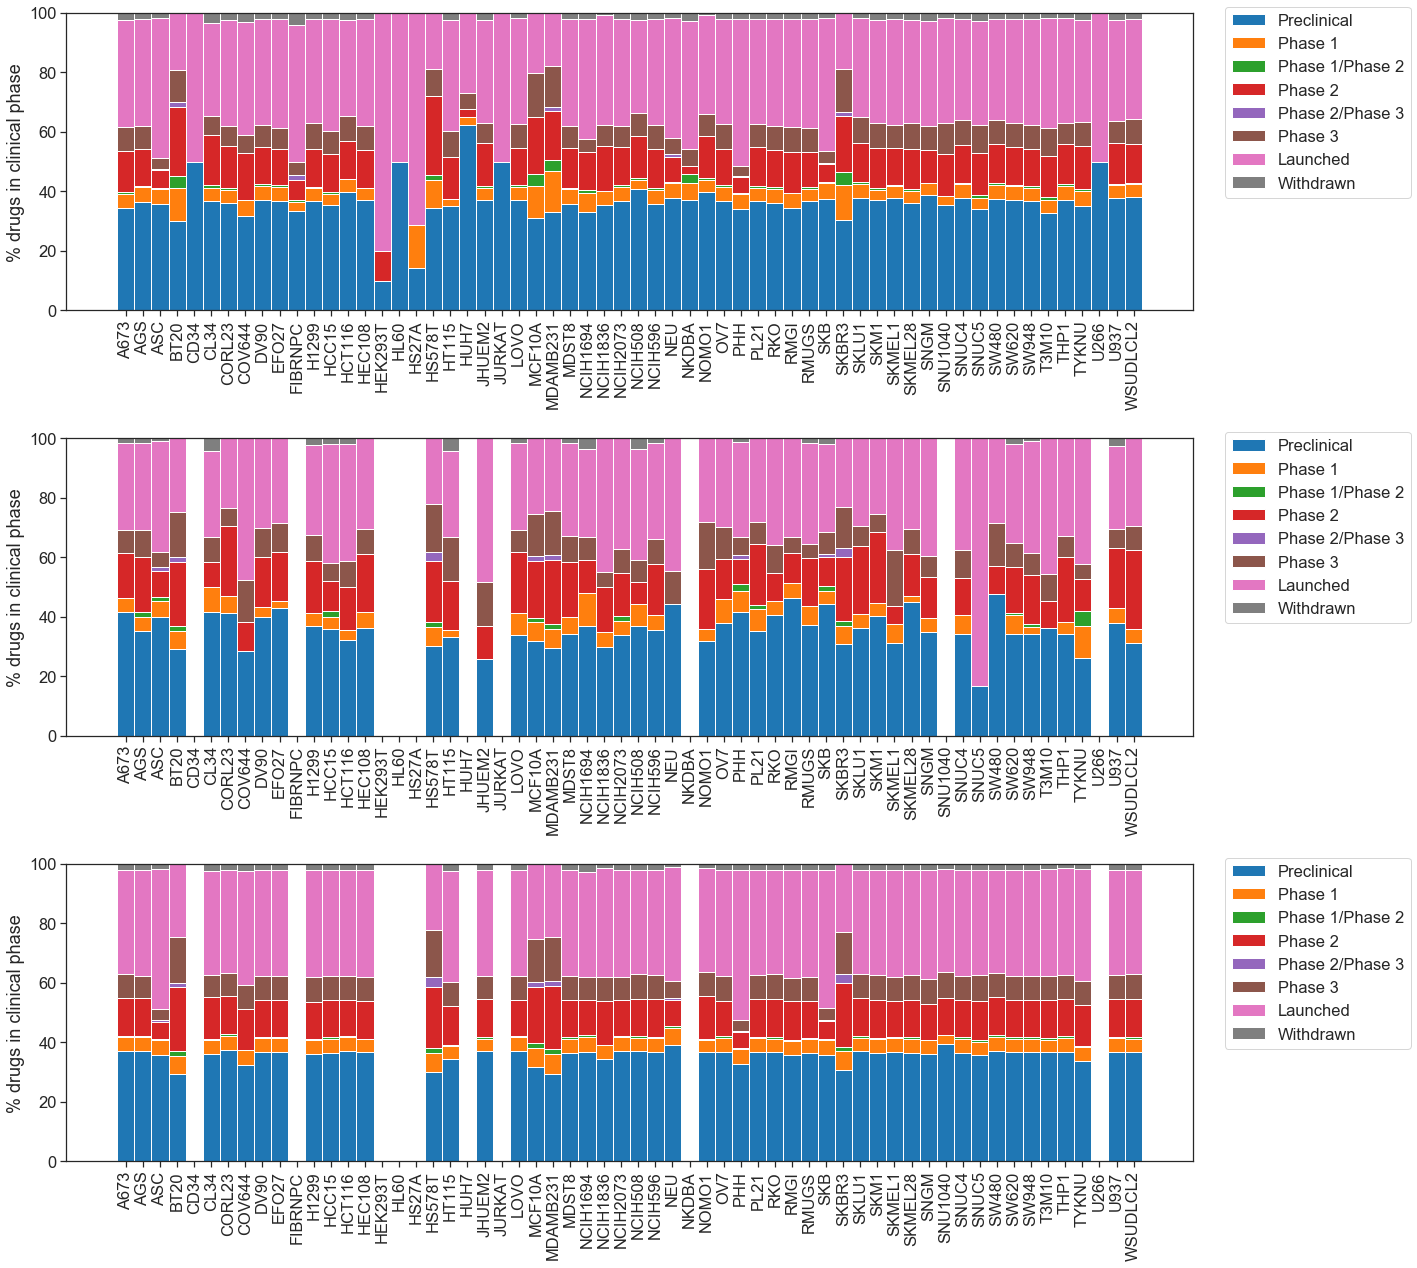

In [186]:
width = 1.0 
cm = plt.get_cmap('tab10')

fig = plt.figure()
fig.set_size_inches(20, 18)
sns.set(font_scale=1.5)
with sns.axes_style("ticks"):
    plt.subplot(3, 1, 1)
    p1 = plt.bar(QUIZC_allcells['Cell_type'], QUIZC_clinical_phase_df.iloc[0], width, label=QUIZC_clinical_phase_df.index[0], color=cm(0))
    for i in np.arange(1, len(QUIZC_clinical_phase_df.index.sort_values())):
        p2 = plt.bar(QUIZC_allcells['Cell_type'], QUIZC_clinical_phase_df.iloc[i], width, bottom=QUIZC_clinical_phase_df.cumsum().iloc[i-1], 
                     label=QUIZC_clinical_phase_df.index[i], color=cm(i))
    plt.xticks(rotation=90)
    plt.ylabel('% drugs in clinical phase')
    plt.legend(bbox_to_anchor=[1.20, 0.70], loc='right')
    
    plt.subplot(3, 1, 2)
    p1 = plt.bar(QUIZC_allcells['Cell_type'], MODZ_clinical_phase_df.iloc[0], width, label=MODZ_clinical_phase_df.index[0], color=cm(0))
    for i in np.arange(1, len(MODZ_clinical_phase_df.index.sort_values())):
        p2 = plt.bar(QUIZC_allcells['Cell_type'], MODZ_clinical_phase_df.iloc[i], width, bottom=MODZ_clinical_phase_df.cumsum().iloc[i-1], 
                     label=MODZ_clinical_phase_df.index[i], color=cm(i))
    plt.xticks(rotation=90)
    plt.ylabel('% drugs in clinical phase')
    plt.legend(bbox_to_anchor=[1.20, 0.70], loc='right')
    
    plt.subplot(3, 1, 3)
    p1 = plt.bar(QUIZC_allcells['Cell_type'], CD_clinical_phase_df.iloc[0], width, label=CD_clinical_phase_df.index[0], color=cm(0))
    for i in np.arange(1, len(CD_clinical_phase_df.index.sort_values())):
        p2 = plt.bar(QUIZC_allcells['Cell_type'], CD_clinical_phase_df.iloc[i], width, bottom=CD_clinical_phase_df.cumsum().iloc[i-1], 
                     label=CD_clinical_phase_df.index[i], color=cm(i))
    plt.xticks(rotation=90)
    plt.ylabel('% drugs in clinical phase')
    plt.legend(bbox_to_anchor=[1.20, 0.70], loc='right')    
    
    plt.tight_layout()
    plt.savefig(proj_output_path + 'clinical_phase_breakdown_all.pdf', format='pdf')
    plt.show()

### Clinical phase vs cell line representation and out-degree (Figures 3B-C, Supp. Figs. 9C-F)
In all three methods, investigational drugs appear in more cell lines than experimental drugs, which in turn appear in more cell lines than approved drugs. In QUIZC, this difference is significant between all pairs of phases (exp. vs inv. pvalue=; exp. vs appr. pvalue=; etc.). In LCB and CD, invedtigational drugs appear in more cell lines than approved and experimental drugs, however, the difference between approved and experimental drugs is not significant. <br>

In terms of out-degree, investigational drugs have a higher out-degree (i.e. higher number of target genes) compared to approved and experimental drugs. This difference is significant for investigational vs. approved for all three methods; and investigational vs approved AND experimental for for LCB and CD. <br>

In [187]:
DRH_QUIZC_drugs = DRH_drugs[DRH_drugs['pert_iname'].isin(QUIZC_alldrugs['Pert_iname'])]
DRH_MODZ_drugs = DRH_drugs[DRH_drugs['pert_iname'].isin(MODZ_alldrugs['Pert_iname'])]
DRH_CD_drugs = DRH_drugs[DRH_drugs['pert_iname'].isin(CD_alldrugs['Pert_iname'])]

DRH_QUIZC_drugs_cellno = pd.merge(DRH_QUIZC_drugs, QUIZC_norm_out_degree_cellno_df, left_on='pert_iname', right_index=True, how='left')
DRH_MODZ_drugs_cellno = pd.merge(DRH_MODZ_drugs, MODZ_norm_out_degree_cellno_df, left_on='pert_iname', right_index=True, how='left')
DRH_CD_drugs_cellno = pd.merge(DRH_CD_drugs, CD_norm_out_degree_cellno_df, left_on='pert_iname', right_index=True, how='left')

#### QUIZC

In [188]:
DRH_QUIZC_drugs_cellno['Exp/Inv/Appr'] = 'Approved' 
preclinical_ix = DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['clinical_phase'].isin(['Preclinical'])].index 
investigational_ix = DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['clinical_phase'].isin(['Phase 1', 'Phase 1/Phase 2', 
                                                                                         'Phase 2', 'Phase 2/Phase 3', 'Phase 3'])].index 
approved_ix = DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['clinical_phase'].isin(['Launched'])].index 
DRH_QUIZC_drugs_cellno.loc[preclinical_ix, 'Exp/Inv/Appr'] = 'Experimental'
DRH_QUIZC_drugs_cellno.loc[investigational_ix, 'Exp/Inv/Appr'] = 'Investigational'
DRH_QUIZC_drugs_cellno.loc[approved_ix, 'Exp/Inv/Appr'] = 'Approved'

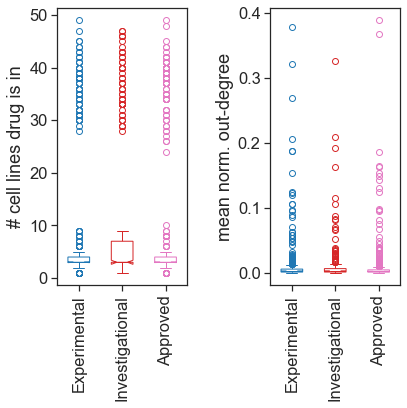

In [199]:
fig = plt.figure()
fig.set_size_inches(6, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    plt.subplot(1, 2, 1)
    
    box1 = plt.boxplot(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'], widths=0.5,
                       positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color=cm(0))
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor=cm(0))  
    
    box2 = plt.boxplot(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'], widths=0.5,
                       positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color=cm(3))
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor=cm(3)) 
        
    box3 = plt.boxplot(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'], widths=0.5,
                       positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color=cm(6))
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor=cm(6)) 
    
    plt.xticks(np.arange(1, 4),  ['Experimental', 'Investigational', 'Approved'])
    plt.xticks(rotation=90)
    plt.ylabel('# cell lines drug is in')
    #plt.ylim(0, 10)

    plt.subplot(1, 2, 2)
    box1 = plt.boxplot(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'], widths=0.5,
                       positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color=cm(0))
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor=cm(0))  
    
    box2 = plt.boxplot(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'], widths=0.5,
                       positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color=cm(3))
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor=cm(3)) 
        
    box3 = plt.boxplot(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'], widths=0.5,
                       positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color=cm(6))
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor=cm(6)) 
    
    plt.xticks(np.arange(1, 4),  ['Experimental', 'Investigational', 'Approved'])
    plt.xticks(rotation=90)
    plt.ylabel('mean norm. out-degree')
    #plt.ylim(0, 0.05)

    plt.tight_layout()
    plt.savefig(proj_output_path + 'ExpInvAppr_cellno_outdeg_QUIZ-C.pdf', format='pdf')   
    plt.show()

In [195]:
print(st.mannwhitneyu(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values, 
                      DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      st.mannwhitneyu(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values, 
                      DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      st.mannwhitneyu(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values, 
                      DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values))

print(np.mean(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      np.mean(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      np.mean(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values))

print(np.std(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      np.std(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      np.std(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values))

MannwhitneyuResult(statistic=57280.0, pvalue=0.01604248469354685) MannwhitneyuResult(statistic=65900.5, pvalue=2.696579090342959e-07) MannwhitneyuResult(statistic=140622.0, pvalue=3.4721448031140665e-05)
6.906153846153846 8.133333333333333 10.17716535433071
10.988334750621496 11.919019687165145 13.65304436055346


In [196]:
print(st.mannwhitneyu(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values, 
                      DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values),
      st.mannwhitneyu(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values, 
                      DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values), 
      st.mannwhitneyu(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values, 
                      DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values))

print(np.mean(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values), 
      np.mean(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values),
      np.mean(DRH_QUIZC_drugs_cellno[DRH_QUIZC_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values))

MannwhitneyuResult(statistic=62499.0, pvalue=0.4481308831044164) MannwhitneyuResult(statistic=75472.0, pvalue=0.022442477870609524) MannwhitneyuResult(statistic=147605.0, pvalue=0.008336700544764788)
0.00803712067465427 0.010619667814554609 0.0110932824120877


#### MODZ

In [197]:
DRH_MODZ_drugs_cellno['Exp/Inv/Appr'] = 'Approved' 
preclinical_ix = DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['clinical_phase'].isin(['Preclinical'])].index 
investigational_ix = DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['clinical_phase'].isin(['Phase 1', 'Phase 1/Phase 2', 
                                                                                         'Phase 2', 'Phase 2/Phase 3', 'Phase 3'])].index 
approved_ix = DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['clinical_phase'].isin(['Launched'])].index 
DRH_MODZ_drugs_cellno.loc[preclinical_ix, 'Exp/Inv/Appr'] = 'Experimental'
DRH_MODZ_drugs_cellno.loc[investigational_ix, 'Exp/Inv/Appr'] = 'Investigational'
DRH_MODZ_drugs_cellno.loc[approved_ix, 'Exp/Inv/Appr'] = 'Approved'

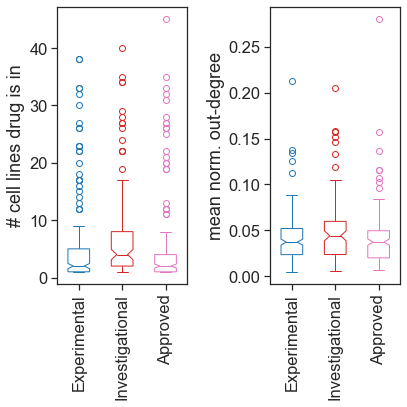

In [200]:
fig = plt.figure()
fig.set_size_inches(6, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    plt.subplot(1, 2, 1)
    
    box1 = plt.boxplot(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'], widths=0.5,
                       positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color=cm(0))
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor=cm(0))  
    
    box2 = plt.boxplot(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'], widths=0.5,
                       positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color=cm(3))
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor=cm(3)) 
        
    box3 = plt.boxplot(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'], widths=0.5,
                       positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color=cm(6))
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor=cm(6)) 
    
    plt.xticks(np.arange(1, 4),  ['Experimental', 'Investigational', 'Approved'])
    plt.xticks(rotation=90)
    plt.ylabel('# cell lines drug is in')
    #plt.ylim(0, 10)

    plt.subplot(1, 2, 2)
    box1 = plt.boxplot(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'], widths=0.5,
                       positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color=cm(0))
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor=cm(0))  
    
    box2 = plt.boxplot(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'], widths=0.5,
                       positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color=cm(3))
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor=cm(3)) 
        
    box3 = plt.boxplot(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'], widths=0.5,
                       positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color=cm(6))
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor=cm(6)) 
    
    plt.xticks(np.arange(1, 4),  ['Experimental', 'Investigational', 'Approved'])
    plt.xticks(rotation=90)
    plt.ylabel('mean norm. out-degree')
    #plt.ylim(0, 0.05)

    plt.tight_layout()
    plt.savefig(proj_output_path + 'ExpInvAppr_cellno_outdeg_MODZ.pdf', format='pdf')   
    plt.show()

In [201]:
print(st.mannwhitneyu(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values, 
                      DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      st.mannwhitneyu(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values, 
                      DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      st.mannwhitneyu(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values, 
                      DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values))

print(np.mean(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      np.mean(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      np.mean(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values))

MannwhitneyuResult(statistic=7574.5, pvalue=3.6574987723618145e-05) MannwhitneyuResult(statistic=6979.0, pvalue=1.2481710375404748e-05) MannwhitneyuResult(statistic=16988.5, pvalue=0.4550775127981515)
4.961111111111111 5.21578947368421 7.577981651376147


In [202]:
print(st.mannwhitneyu(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values, 
                      DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values),
      st.mannwhitneyu(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values, 
                      DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values), 
      st.mannwhitneyu(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values, 
                      DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values))

print(np.mean(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values), 
      np.mean(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values),
      np.mean(DRH_MODZ_drugs_cellno[DRH_MODZ_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values))

MannwhitneyuResult(statistic=9017.5, pvalue=0.03157637742703159) MannwhitneyuResult(statistic=8307.5, pvalue=0.014581117744869582) MannwhitneyuResult(statistic=16654.0, pvalue=0.3324162774194419)
0.04066123904760038 0.040458644562912295 0.04933485856623098


#### CD

In [203]:
DRH_CD_drugs_cellno['Exp/Inv/Appr'] = 'Approved' 
preclinical_ix = DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['clinical_phase'].isin(['Preclinical'])].index 
investigational_ix = DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['clinical_phase'].isin(['Phase 1', 'Phase 1/Phase 2', 
                                                                                         'Phase 2', 'Phase 2/Phase 3', 'Phase 3'])].index 
approved_ix = DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['clinical_phase'].isin(['Launched'])].index 
DRH_CD_drugs_cellno.loc[preclinical_ix, 'Exp/Inv/Appr'] = 'Experimental'
DRH_CD_drugs_cellno.loc[investigational_ix, 'Exp/Inv/Appr'] = 'Investigational'
DRH_CD_drugs_cellno.loc[approved_ix, 'Exp/Inv/Appr'] = 'Approved'

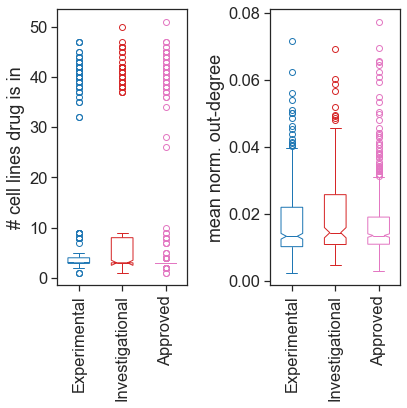

In [204]:
fig = plt.figure()
fig.set_size_inches(6, 6)
sns.set(font_scale=1.5)
with sns.axes_style('ticks'):
    plt.subplot(1, 2, 1)
    
    box1 = plt.boxplot(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'], widths=0.5,
                       positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color=cm(0))
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor=cm(0))  
    
    box2 = plt.boxplot(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'], widths=0.5,
                       positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color=cm(3))
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor=cm(3)) 
        
    box3 = plt.boxplot(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'], widths=0.5,
                       positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color=cm(6))
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor=cm(6)) 
    
    plt.xticks(np.arange(1, 4),  ['Experimental', 'Investigational', 'Approved'])
    plt.xticks(rotation=90)
    plt.ylabel('# cell lines drug is in')
    #plt.ylim(0, 10)

    plt.subplot(1, 2, 2)
    box1 = plt.boxplot(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'], widths=0.5,
                       positions=[1], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color=cm(0))
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor=cm(0))  
    
    box2 = plt.boxplot(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'], widths=0.5,
                       positions=[2], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color=cm(3))
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor=cm(3)) 
        
    box3 = plt.boxplot(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'], widths=0.5,
                       positions=[3], notch=True, patch_artist=True)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color=cm(6))
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor=cm(6)) 
    
    plt.xticks(np.arange(1, 4),  ['Experimental', 'Investigational', 'Approved'])
    plt.xticks(rotation=90)
    plt.ylabel('mean norm. out-degree')
    #plt.ylim(0, 0.05)

    plt.tight_layout()
    plt.savefig(proj_output_path + 'ExpInvAppr_cellno_outdeg_CD.pdf', format='pdf')   
    plt.show()

In [205]:
print(st.mannwhitneyu(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values, 
                      DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      st.mannwhitneyu(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values, 
                      DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      st.mannwhitneyu(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values, 
                      DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values))

print(np.mean(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['# cell lines drug is in'].values), 
      np.mean(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['# cell lines drug is in'].values),
      np.mean(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['# cell lines drug is in'].values))

MannwhitneyuResult(statistic=44589.5, pvalue=4.509007117706878e-06) MannwhitneyuResult(statistic=56016.0, pvalue=2.426483028495226e-08) MannwhitneyuResult(statistic=139582.5, pvalue=0.23810147530690606)
7.857142857142857 9.064102564102564 11.883620689655173


In [206]:
print(st.mannwhitneyu(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values, 
                      DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values),
      st.mannwhitneyu(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values, 
                      DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values), 
      st.mannwhitneyu(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values, 
                      DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values))

print(np.mean(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Approved']['mean norm. out-degree'].values), 
      np.mean(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Experimental']['mean norm. out-degree'].values),
      np.mean(DRH_CD_drugs_cellno[DRH_CD_drugs_cellno['Exp/Inv/Appr']=='Investigational']['mean norm. out-degree'].values))

MannwhitneyuResult(statistic=47656.0, pvalue=0.004229783198401136) MannwhitneyuResult(statistic=63928.0, pvalue=0.016468520842242023) MannwhitneyuResult(statistic=137452.0, pvalue=0.1589661815777592)
0.016615368625433575 0.016672714061321127 0.01935627911107801


### Topological drug specificity within each QUIZC/MODZ/CD network (Figure 3D)

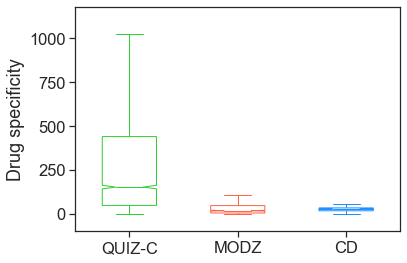

In [231]:
sns.set(font_scale=1.5)
fig = plt.figure()
with sns.axes_style('ticks'):
    box1 = plt.boxplot(1.0/(QUIZC_norm_out_degree_cellno_df['# cell lines drug is in'] * QUIZC_norm_out_degree_cellno_df['mean norm. out-degree']), widths=0.5,
                       positions=[1], notch=True, patch_artist=True, showfliers=False)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box1[item], color='limegreen')
    plt.setp(box1["boxes"], facecolor='white')
    plt.setp(box1["fliers"], markeredgecolor='limegreen')

    box2 = plt.boxplot(1.0/(MODZ_norm_out_degree_cellno_df['# cell lines drug is in'] * MODZ_norm_out_degree_cellno_df['mean norm. out-degree']), widths=0.5,
                       positions=[2], notch=True, patch_artist=True, showfliers=False)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box2[item], color='tomato')
    plt.setp(box2["boxes"], facecolor='white')
    plt.setp(box2["fliers"], markeredgecolor='tomato')
    
    box3 = plt.boxplot(1.0/(CD_norm_out_degree_cellno_df['# cell lines drug is in'] * CD_norm_out_degree_cellno_df['mean norm. out-degree']), widths=0.5,
                       positions=[3], notch=True, patch_artist=True, showfliers=False)
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(box3[item], color='dodgerblue')
    plt.setp(box3["boxes"], facecolor='white')
    plt.setp(box3["fliers"], markeredgecolor='dodgerblue')
   
    plt.xticks([1, 2, 3], ['QUIZ-C', 'MODZ', 'CD'])
    plt.ylim(-100, 1180)
    plt.ylabel('Drug specificity')
    plt.tight_layout()
    plt.savefig(proj_output_path + 'Drug_specificity_boxplots_nofliers.pdf', format='pdf')
    plt.show()

In [233]:
st.mannwhitneyu(1.0/(MODZ_norm_out_degree_cellno_df['# cell lines drug is in'] * MODZ_norm_out_degree_cellno_df['mean norm. out-degree']),
                1.0/(QUIZC_norm_out_degree_cellno_df['# cell lines drug is in'] * QUIZC_norm_out_degree_cellno_df['mean norm. out-degree']))

MannwhitneyuResult(statistic=555625.0, pvalue=3.4426238347338535e-232)

In [234]:
st.mannwhitneyu(1.0/(CD_norm_out_degree_cellno_df['# cell lines drug is in'] * CD_norm_out_degree_cellno_df['mean norm. out-degree']),
                1.0/(QUIZC_norm_out_degree_cellno_df['# cell lines drug is in'] * QUIZC_norm_out_degree_cellno_df['mean norm. out-degree']))

MannwhitneyuResult(statistic=1598223.0, pvalue=0.0)

In [235]:
st.mannwhitneyu(1.0/(MODZ_norm_out_degree_cellno_df['# cell lines drug is in'] * MODZ_norm_out_degree_cellno_df['mean norm. out-degree']),
                1.0/(CD_norm_out_degree_cellno_df['# cell lines drug is in'] * CD_norm_out_degree_cellno_df['mean norm. out-degree']))

MannwhitneyuResult(statistic=1128511.0, pvalue=0.0002711836061500949)

### Enrichment of known drug-target edges in QUIZC/MODZ/CD (Figure 3E, Supp. Figs. 10B-E)

In [236]:
# DGIdb filtering -- remove nans, drop duplicates
DGIdb_edges_df = DGIdb_interactions_iname_df[['pert_iname', 'gene_name']]
DGIdb_edges_df = DGIdb_edges_df[~pd.isnull(DGIdb_edges_df['gene_name'])]
DGIdb_edges_df = DGIdb_edges_df.drop_duplicates()
DGIdb_edges_df = DGIdb_edges_df.reset_index(drop=True)

# DRH filtering -- remove nans, rename target column, reset indices, expand target genes into separate rows, drop duplicates
#print(len(DRH_edges_df))
DRH_edges_df = DRH_drugs_samples_df[~pd.isnull(DRH_drugs_samples_df['target'])][['pert_iname', 'target']]
print(len(DRH_edges_df))
DRH_edges_df = DRH_edges_df.rename(columns={'target': 'gene_name'})
DRH_edges_df = pd.DataFrame([x.split('|') for x in DRH_edges_df['gene_name'].tolist()], index=DRH_edges_df['pert_iname'])\
        .stack().reset_index(level=1, drop=True).reset_index(name='gene_name')[['pert_iname', 'gene_name',]]
DRH_edges_df = DRH_edges_df.drop_duplicates()
DRH_edges_df = DRH_edges_df.reset_index(drop=True)

# total numnber of nodes and edges in DGIdb and DRH
print(len(set(DGIdb_edges_df['pert_iname'])), len(set(DRH_edges_df['pert_iname'])))
print(len(DGIdb_edges_df), len(DRH_edges_df))

# merge the drug-target pairs from DGIdb and DRH
DRH_DGIdb_edges_df = pd.merge(DRH_edges_df, DGIdb_edges_df, on=['pert_iname', 'gene_name'], how='outer')

7655
837 4484
5353 13097


In [238]:
f = open(proj_output_path + 'contingency_tables_QUIZC.csv', 'w')
f.write('Cell_type,A,B,C,D\n')
for c in QUIZC_allcells['Cell_type']:
    cell_edges_df = pd.DataFrame(list(QUIZC_diG_dict[c].edges()), columns=['pert_iname', 'gene_name'])

    merged_df = pd.merge(cell_edges_df, DRH_DGIdb_edges_df, on=['pert_iname', 'gene_name'], how='outer', indicator=True)

    A = len(merged_df[merged_df['_merge'] == 'both'])
    B = len(merged_df[merged_df['_merge'] == 'left_only'])
    C = len(merged_df[merged_df['_merge'] == 'right_only'])
    D = (len(set(DRH_DGIdb_edges_df['pert_iname']) | set(cell_edges_df['pert_iname'])) * 
         len(set(DRH_DGIdb_edges_df['gene_name']) | set(cell_edges_df['gene_name']))) - (A + B + C)

    f.write('%s,%s,%s,%s,%s\n' % (c, A, B, C, D))
f.close()


f = open(proj_output_path + 'contingency_tables_MODZ.csv', 'w')
f.write('Cell_type,A,B,C,D\n')
for c in MODZ_allcells['Cell_type']:
    cell_edges_df = pd.DataFrame(list(MODZ_diG_dict[c].edges()), columns=['pert_iname', 'gene_name'])

    merged_df = pd.merge(cell_edges_df, DRH_DGIdb_edges_df, on=['pert_iname', 'gene_name'], how='outer', indicator=True)

    A = len(merged_df[merged_df['_merge'] == 'both'])
    B = len(merged_df[merged_df['_merge'] == 'left_only'])
    C = len(merged_df[merged_df['_merge'] == 'right_only'])
    D = (len(set(DRH_DGIdb_edges_df['pert_iname']) | set(cell_edges_df['pert_iname'])) * 
         len(set(DRH_DGIdb_edges_df['gene_name']) | set(cell_edges_df['gene_name']))) - (A + B + C)

    f.write('%s,%s,%s,%s,%s\n' % (c, A, B, C, D))
f.close()


f = open(proj_output_path + 'contingency_tables_CD.csv', 'w')
f.write('Cell_type,A,B,C,D\n')
for c in CD_allcells['Cell_type']:
    cell_edges_df = pd.DataFrame(list(CD_diG_dict[c].edges()), columns=['pert_iname', 'gene_name'])

    merged_df = pd.merge(cell_edges_df, DRH_DGIdb_edges_df, on=['pert_iname', 'gene_name'], how='outer', indicator=True)

    A = len(merged_df[merged_df['_merge'] == 'both'])
    B = len(merged_df[merged_df['_merge'] == 'left_only'])
    C = len(merged_df[merged_df['_merge'] == 'right_only'])
    D = (len(set(DRH_DGIdb_edges_df['pert_iname']) | set(cell_edges_df['pert_iname'])) * 
         len(set(DRH_DGIdb_edges_df['gene_name']) | set(cell_edges_df['gene_name']))) - (A + B + C)

    f.write('%s,%s,%s,%s,%s\n' % (c, A, B, C, D))
f.close()

# --> Process output in R ("overlap_CIs.R") to get the confidence intervals

In [241]:
QUIZC_fisher_pvals = pd.read_csv(proj_output_path + 'edge_overlap_pvals_QUIZC.csv', index_col=0)
MODZ_fisher_pvals = pd.read_csv(proj_output_path + 'edge_overlap_pvals_MODZ.csv', index_col=0)
CD_fisher_pvals = pd.read_csv(proj_output_path + 'edge_overlap_pvals_CD.csv', index_col=0)

QUIZC_fisher_pvals = QUIZC_fisher_pvals.rename(columns={'pval': 'pval_QUIZC', 'logpval': 'logpval_QUIZC', 
                                                      'OR': 'OR_QUIZC', 'OR_CI1': 'OR_CI1_QUIZC', 'OR_CI2': 'OR_CI2_QUIZC'})
MODZ_fisher_pvals = MODZ_fisher_pvals.rename(columns={'pval': 'pval_MODZ', 'logpval': 'logpval_MODZ', 
                                                      'OR': 'OR_MODZ', 'OR_CI1': 'OR_CI1_MODZ', 'OR_CI2': 'OR_CI2_MODZ'})
CD_fisher_pvals = CD_fisher_pvals.rename(columns={'pval': 'pval_CD', 'logpval': 'logpval_CD', 
                                                      'OR': 'OR_CD', 'OR_CI1': 'OR_CI1_CD', 'OR_CI2': 'OR_CI2_CD'})

fisher_pvals_merged = pd.merge(pd.merge(QUIZC_fisher_pvals, MODZ_fisher_pvals, left_index=True, right_index=True, how='left'), 
                               CD_fisher_pvals, left_index=True, right_index=True, how='left')

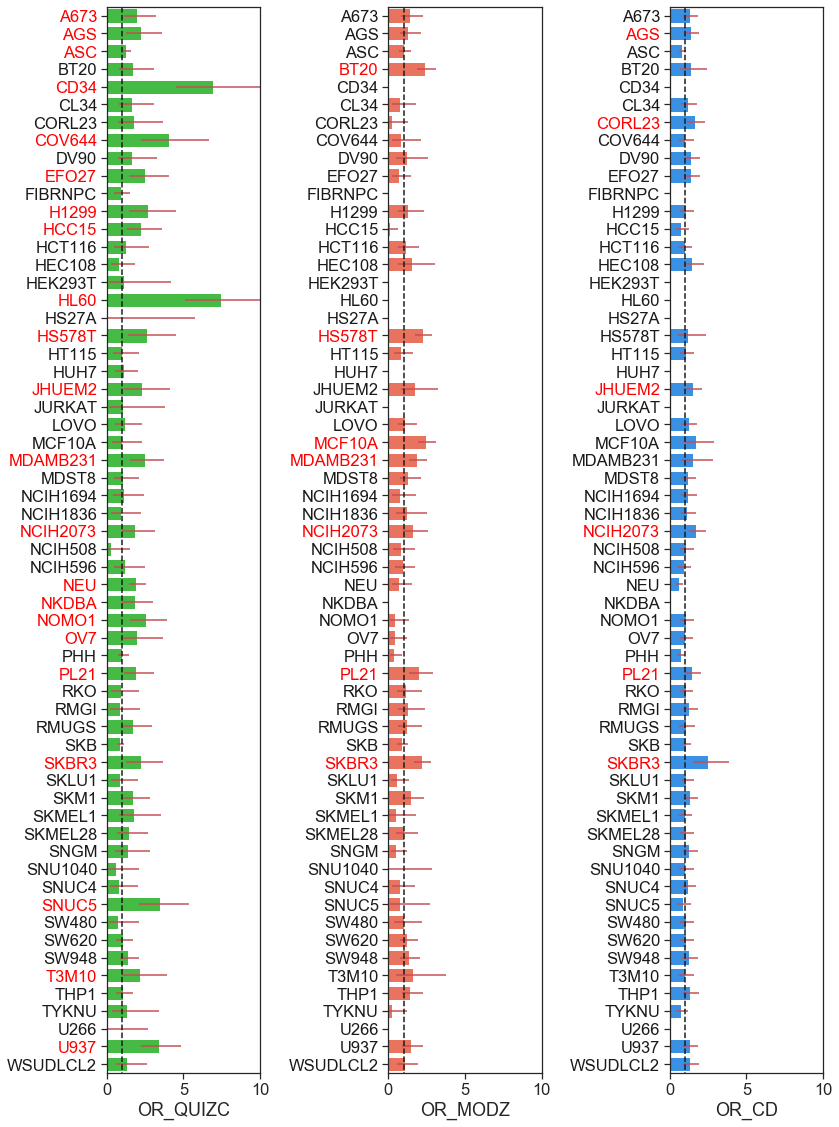

In [244]:
fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(font_scale=1.5)
with sns.axes_style("ticks"):
    plt.subplot(1, 3, 1)
    xerr = [fisher_pvals_merged['OR_QUIZC'] - fisher_pvals_merged['OR_CI1_QUIZC'], fisher_pvals_merged['OR_CI2_QUIZC'] - fisher_pvals_merged['OR_QUIZC']]
    ax = sns.barplot(y=fisher_pvals_merged.index, x='OR_QUIZC', data=fisher_pvals_merged, orient='h', color='limegreen')
    plt.errorbar(x=fisher_pvals_merged['OR_QUIZC'], y=np.arange(len(QUIZC_allcells)), xerr=xerr, fmt='none', c= 'r')
    colors = ['red' if (p<=0.05) & (o>=1.0) else 'k' for p, o in fisher_pvals_merged[['pval_QUIZC', 'OR_QUIZC']].values]
    for color, tick in zip(colors, ax.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    plt.plot([1, 1], [-0.5, 60.5], 'k--')
    plt.xlim(0, 10)
    plt.ylim(len(QUIZC_allcells)-0.5, -0.5)
    
    plt.subplot(1, 3, 2)
    xerr = [fisher_pvals_merged['OR_MODZ'] - fisher_pvals_merged['OR_CI1_MODZ'], fisher_pvals_merged['OR_CI2_MODZ'] - fisher_pvals_merged['OR_MODZ']]
    ax = sns.barplot(y=fisher_pvals_merged.index, x='OR_MODZ', data=fisher_pvals_merged, orient='h', color='tomato')
    plt.errorbar(x=fisher_pvals_merged['OR_MODZ'], y=np.arange(len(QUIZC_allcells)), xerr=xerr, fmt='none', c= 'r')
    colors = ['red' if (p<=0.05) & (o>=1.0) else 'k' for p, o in fisher_pvals_merged[['pval_MODZ', 'OR_MODZ']].values]
    for color, tick in zip(colors, ax.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    plt.plot([1, 1], [-0.5, 60.5], 'k--')
    plt.xlim(0, 10)
    plt.ylim(len(QUIZC_allcells)-0.5, -0.5)
    
    plt.subplot(1, 3, 3)
    xerr = [fisher_pvals_merged['OR_CD'] - fisher_pvals_merged['OR_CI1_CD'], fisher_pvals_merged['OR_CI2_CD'] - fisher_pvals_merged['OR_CD']]
    ax = sns.barplot(y=fisher_pvals_merged.index, x='OR_CD', data=fisher_pvals_merged, orient='h', color='dodgerblue')
    plt.errorbar(x=fisher_pvals_merged['OR_CD'], y=np.arange(len(QUIZC_allcells)), xerr=xerr, fmt='none', c= 'r')
    colors = ['red' if (p<=0.05) & (o>=1.0) else 'k' for p, o in fisher_pvals_merged[['pval_CD', 'OR_CD']].values]
    for color, tick in zip(colors, ax.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    plt.plot([1, 1], [-0.5, 60.5], 'k--')
    plt.xlim(0, 10)
    plt.ylim(len(QUIZC_allcells)-0.5, -0.5)
    
    plt.tight_layout()
    
    plt.savefig(proj_output_path + 'known_DT_overlap_Fisher_CI_all.pdf', format='pdf')
    plt.show()

In [245]:
22.0 / 46, 7.0 / 46, 6.0 / 46

(0.4782608695652174, 0.15217391304347827, 0.13043478260869565)

/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ardahalu/anaconda3/envs/py3_main/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


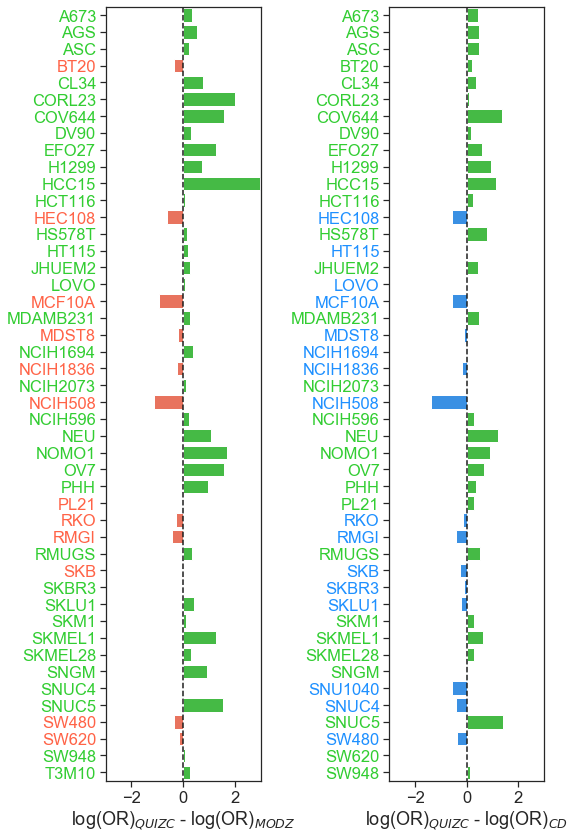

In [246]:
fig = plt.figure()
fig.set_size_inches(8, 12)
sns.set(font_scale=1.5)
with sns.axes_style("ticks"):
    plt.subplot(1, 2, 1)
    logOR_diff_df = pd.DataFrame(np.log(fisher_pvals_merged['OR_QUIZC']) - np.log(fisher_pvals_merged['OR_MODZ'])).replace([np.inf, -np.inf], np.nan).dropna()
    colors = ['limegreen' if o>=0 else 'tomato' for o in logOR_diff_df[0].values]
    ax = sns.barplot(y=logOR_diff_df.index, x=0, data=logOR_diff_df, orient='h', palette=colors)
    for color, tick in zip(colors, ax.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    plt.plot([0, 0], [-0.5, 60.5], 'k--')
    plt.xlim(-3, 3)
    plt.ylim(45.5, -0.5)
    plt.xlabel(r'log(OR)$_{QUIZC}$ - log(OR)$_{MODZ}$')    
    
    
    plt.subplot(1, 2, 2)
    logOR_diff_df = pd.DataFrame(np.log(fisher_pvals_merged['OR_QUIZC']) - np.log(fisher_pvals_merged['OR_CD'])).replace([np.inf, -np.inf], np.nan).dropna()
    colors = ['limegreen' if o>=0 else 'dodgerblue' for o in logOR_diff_df[0].values]
    ax = sns.barplot(y=logOR_diff_df.index, x=0, data=logOR_diff_df, orient='h', palette=colors)
    for color, tick in zip(colors, ax.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    plt.plot([0, 0], [-0.5, 60.5], 'k--')
    plt.xlim(-3, 3)
    plt.ylim(45.5, -0.5)
    plt.xlabel(r'log(OR)$_{QUIZC}$ - log(OR)$_{CD}$')
    
    plt.tight_layout()
    plt.savefig(proj_output_path + 'known_DT_overlap_Fisher_logOR_diff.pdf', format='pdf')
    plt.show()

In [247]:
12.0 /46, 16.0/46

(0.2608695652173913, 0.34782608695652173)

## Benchmark

In [248]:
def process_MSigDB_CGP(cgp_dir):
    
    cgp = {}
    f = open(cgp_dir)
    for line in f:
        line = line.rstrip()
        cgp[line.split('http://')[0].split('\t')[0]] = line.split('http://')[1].split('\t')[1:]
    f.close()
        
    # identify the indices of the duplicates (after removing _UP and DN) to determine the genesets that have both _UP and _DN
    cgp_ix = pd.DataFrame(index=cgp.keys())
    cgp_ix = cgp_ix[(cgp_ix.index.str.endswith('_UP')) | (cgp_ix.index.str.endswith('_DN'))]
    cgp_ix = cgp_ix[cgp_ix.index.str[:-3].duplicated(keep=False)]

    # CGP dictionary with only the genesets with UP and DN
    cgp_updn = {i: cgp[i] for i in cgp_ix.index.values}
        
    cgp_updn_allgenes = set([j for i in cgp_updn.values() for j in i])
    cgp_updn_labels = sorted(list(set(cgp_ix.index.str[:-3])))
   
    return cgp_updn, cgp_updn_labels, cgp_updn_allgenes

In [249]:
def import_TDD(TTD_drugs_path, TTD_InChI2CID_path, TTD_drug_target_path, TTD_target_path):
    
    TTD_drugs = pd.read_csv(TTD_drugs_path, sep='\t', skiprows=29)
    TTD_InChI2CID = pd.read_csv(TTD_InChI2CID_path, sep='\t', header=None)
    TTD_drugs_CID = pd.merge(TTD_drugs[TTD_drugs['DRUG__ID']=='DRUGINKE'], TTD_InChI2CID, left_on='D00AAN.1', right_on=0)
    TTD_drug_target = pd.read_csv(TTD_drug_target_path)

    f = open(TTD_target_path, 'r')
    TTD_targID_dict = {}
    for line in f:
        line = line.split('\t')
        if len(line) == 3:
            if line[1] == 'GENENAME':
                TTD_targID_dict[line[2].strip('\n')] = line[0]
    f.close()
    
    return TTD_drugs, TTD_InChI2CID, TTD_drugs_CID, TTD_drug_target, TTD_targID_dict

In [250]:
def get_geneset_targets(geneset_up, geneset_dn, TTD_targID_dict, TTD_drug_target, TTD_drugs_CID, pert_iname2CID):

    # getting the direct targets of the input geneset from TTD
    geneset_targetIDs = [TTD_targID_dict[i] for i in list(set(TTD_targID_dict.keys()) & (geneset_dn | geneset_up))]
    geneset_drugID_targetID = TTD_drug_target[TTD_drug_target['TargetID'].isin(geneset_targetIDs)]
    geneset_drugCIDs = TTD_drugs_CID[TTD_drugs_CID['D00AAN'].isin(geneset_drugID_targetID['DrugID'])]
    geneset_drugID_targetCID = pd.merge(geneset_drugID_targetID, geneset_drugCIDs, left_on='DrugID', right_on='D00AAN', how='left')


    # Get the subset of drugs targeting the given pathway above that is within the QUIZC drugs by
    # (1) first getting the lookup table between CIDs, InCHI Keys, SMILES and pert_inames of QUIZC compounds;
    # (2) then subsetting the drugs targeting the given pathway by the ones that are in QUIZC, in terms of their pert_inames.
    # The resulting number of compounds is naturally small since the drugs in QUIZC networks are a small subset of all the drugs 
    # in the TTD database.

    geneset_targets_pert_iname = pd.merge(geneset_drugID_targetCID, pert_iname2CID, 
                                                    left_on=1, right_on='pubchem_cid_x', how='left')
    geneset_targets_pert_iname = geneset_targets_pert_iname[~pd.isnull(geneset_targets_pert_iname['Pert_iname'])]

    return set(geneset_targets_pert_iname['Pert_iname'])

In [251]:
def get_MSigDB_geneset_targets(cgp_updn_labels, cgp_updn, TTD_targID_dict, TTD_drug_target, TTD_drugs_CID, pert_iname2CID):
    
    geneset_pert_iname_dict = {}
    for geneset_name in tqdm(cgp_updn_labels, position=0, leave=True):

        geneset_up = set(cgp_updn[geneset_name + '_UP'])
        geneset_dn = set(cgp_updn[geneset_name + '_DN'])        
        geneset_pert_iname_dict[geneset_name] = get_geneset_targets(geneset_up, geneset_dn, TTD_targID_dict, TTD_drug_target, 
                                                                         TTD_drugs_CID, pert_iname2CID)
        
    return geneset_pert_iname_dict

In [252]:
def import_Enrichr_GEO(Enrichr_GEO_up_path, Enrichr_GEO_dn_path):

    Enrichr_GEO_disease_human_up = {}
    f = open(Enrichr_GEO_up_path)
    for line in f:
        line = line.rstrip()
        d = line.split('\t')[0]
        g = line.split('\t')[2:]
        if 'human' in d:
            Enrichr_GEO_disease_human_up[d] = g       
    f.close()

    Enrichr_GEO_disease_human_dn = {}
    f = open(Enrichr_GEO_dn_path)
    for line in f:
        line = line.rstrip()
        d = line.split('\t')[0]
        g = line.split('\t')[2:]
        if 'human' in d:
            Enrichr_GEO_disease_human_dn[d] = g       
    f.close()
    
    return Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn

In [253]:
# Calculate the Signature Congruity Score (SCS) between two genesets, typically an input signature (or perturbation) and a disease signature.
def SCS(geneset_up, geneset_dn, disease_up, disease_dn):
        
        if len((geneset_up | geneset_dn) & (disease_up | disease_dn)) > 0:
            SCS_g_d = 1.0 * ((len(disease_up & geneset_up) + len(disease_dn & geneset_dn) 
                       - len(disease_dn & geneset_up) - len(disease_up & geneset_dn)) / len(disease_up | disease_dn))
            return SCS_g_d
        else:
            return np.nan        

In [254]:
def PCP_geneset(geneset_up, geneset_dn, disease_sig_up_dict, disease_sig_dn_dict, geneset_name='Geneset'):

    PCP_geneset_df = pd.DataFrame(index=[geneset_name], columns=sorted(disease_sig_up_dict.keys()), dtype='float')
    
    for d in disease_sig_up_dict.keys():
        disease_up = set(disease_sig_up_dict[d])
        disease_dn = set(disease_sig_dn_dict[d])    
        
        PCP_geneset_df.at[geneset_name, d] = SCS(geneset_up, geneset_dn, disease_up, disease_dn)
        
    return PCP_geneset_df

In [255]:
def PCP_geneset_allMsigDB(cgp_updn, cgp_updn_labels, disease_sig_up_dict, disease_sig_dn_dict):
    
    PCP_geneset_allMsigDB_df = pd.DataFrame(index=cgp_updn_labels, columns=sorted(disease_sig_up_dict.keys()), dtype='float')
        
    for geneset_name in tqdm(cgp_updn_labels, position=0, leave=True):
        geneset_up = set(cgp_updn[geneset_name + '_UP'])
        geneset_dn = set(cgp_updn[geneset_name + '_DN'])        
        
        for d in disease_sig_up_dict.keys():
            disease_up = set(disease_sig_up_dict[d])
            disease_dn = set(disease_sig_dn_dict[d])    

            PCP_geneset_allMsigDB_df.at[geneset_name, d] = SCS(geneset_up, geneset_dn, disease_up, disease_dn)
            
    return PCP_geneset_allMsigDB_df    

In [324]:
def PCP_perturbation(perturbation, allcells, edgelist_df_dict, disease_sig_up_dict, disease_sig_dn_dict):

    PCP_perturbation_df = pd.DataFrame(index=allcells['Cell_type'], columns=sorted(disease_sig_up_dict.keys()), dtype='float')
    
    for c in allcells['Cell_type']:

        cell_drugs = sorted(list(set(edgelist_df_dict[c]['Drug'])))

        if perturbation in cell_drugs:

            cell_sorted_df = edgelist_df_dict[c].sort_values(['Drug', 'Target']) 
            drug_up = set(cell_sorted_df[(cell_sorted_df['Drug']==perturbation) & (cell_sorted_df['Direction']=='Up')]['Target'].values)
            drug_dn = set(cell_sorted_df[(cell_sorted_df['Drug']==perturbation) & (cell_sorted_df['Direction']=='Down')]['Target'].values)

            for d in disease_sig_up_dict.keys():
                disease_up = set(disease_sig_up_dict[d])
                disease_dn = set(disease_sig_dn_dict[d])    

                PCP_perturbation_df.at[c, d] = SCS(drug_up, drug_dn, disease_up, disease_dn)

        else:
            PCP_perturbation_df = PCP_perturbation_df.drop(c)
            
    return PCP_perturbation_df

In [638]:
def PCP_perturbation_alldrugs(alldrugs, allcells, edgelist_df_dict, disease_sig_up_dict, disease_sig_dn_dict, 
                              proj_path, method_name, return_output=False):
    
    if not os.path.exists(proj_path + method_name + '_pcp_perturbation_df_dict.pickle'):
        
        print('Calculating PCPs for all perturbations...', flush=True)
        PCP_perturbation_df_dict = {}

        for drug in tqdm(alldrugs['Pert_iname'], position=0, leave=True):

            PCP_perturbation_df_dict[drug] = PCP_perturbation(drug, allcells, edgelist_df_dict, disease_sig_up_dict, disease_sig_dn_dict)

        with open(proj_path + method_name + '_pcp_perturbation_df_dict.pickle', 'wb') as fp:
            pickle.dump(PCP_perturbation_df_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
        if return_output==True:  
            return PCP_perturbation_df_dict
                
    else:
        
        print('Reading PCPs for all perturbations...', flush=True)
        with open(proj_path + method_name + '_pcp_perturbation_df_dict.pickle', 'rb') as fp:
            PCP_perturbation_df_dict = pickle.load(fp)      
    
        if return_output==True:  
            return PCP_perturbation_df_dict

In [442]:
def calculate_auroc(TPR, FPR):
    
    dTPR = np.concatenate((np.ediff1d(TPR), [0]))
    dFPR = np.concatenate((np.ediff1d(FPR), [0]))
    
    return sum(TPR * dFPR) + sum(dTPR * dFPR)/2

In [443]:
def AUROC_AUPRC(ranked_array, positives, auc_threshold=5, binsize=1):

    ranked_array_positives = set(ranked_array) & positives                 
    
    if len(ranked_array_positives) >= auc_threshold:
        
        bins = np.arange(1, len(ranked_array), binsize)      
        TPR = np.zeros(len(bins))
        FPR = np.zeros(len(bins))
        precision = np.zeros(len(bins))
        recall = np.zeros(len(bins))    

        for i, n in enumerate(bins):

            topN = ranked_array[0:n]

            overlap = set(topN) & ranked_array_positives

            TP = 1.0 * len(overlap)
            FP = len(topN) - TP
            FN = len(ranked_array_positives) - TP
            TN = len(ranked_array) - (TP + FP + FN)
            TPR[i] = TP / (TP + FN)
            FPR[i] = FP / (FP + TN)
            precision[i] = TP / (TP + FP)
            recall[i] = TP / (TP + FN)

        auroc = calculate_auroc(TPR, FPR)
        auprc = calculate_auroc(precision, recall)
    
        return auroc, auprc
    
    else:
        return np.nan, np.nan

In [673]:
def PACOS(PCP_geneset_df, PCP_perturbation_df_dict, alldrugs, allcells, tool_scores, 
          proj_path, method_name, geneset_name, r=2.0, threshold=10, tqdm_off=False, messages=False):

    if not os.path.exists(proj_path +  '%s_%s_r%s.csv' % (method_name, geneset_name, int(r))):
        
        if messages: print('Running Pathopticon...', flush=True)
        PACOS_spearman_rho_df = pd.DataFrame(index=alldrugs['Pert_iname'], columns=allcells['Cell_type'], dtype='float')
        PACOS_spearman_pval_df = pd.DataFrame(index=alldrugs['Pert_iname'], columns=allcells['Cell_type'], dtype='float')
        
        for drug in tqdm(alldrugs['Pert_iname'], position=0, leave=True, disable=tqdm_off):

            for c in PCP_perturbation_df_dict[drug].index:
                common_diseases = set(PCP_geneset_df.loc[geneset_name][~pd.isnull(PCP_geneset_df.loc[geneset_name])].index) &\
                                    set(PCP_perturbation_df_dict[drug].loc[c][~pd.isnull(PCP_perturbation_df_dict[drug].loc[c])].index)
                if len(common_diseases) >= threshold:
                    PACOS_spearman_rho_df.at[drug, c], PACOS_spearman_pval_df.at[drug, c] = st.spearmanr(PCP_geneset_df.loc[geneset_name][common_diseases], 
                                                                      PCP_perturbation_df_dict[drug].loc[c][common_diseases])

        PACOS_spearman_rho_df[pd.isnull(PACOS_spearman_rho_df)] = -666
        sorted_ix = np.argsort(PACOS_spearman_rho_df.values.flatten())
        nonan_len = len(PACOS_spearman_rho_df.values.flatten()[PACOS_spearman_rho_df.values.flatten()!=-666])
        nonan_ranked = PACOS_spearman_rho_df.values.flatten()[np.flip(sorted_ix)[0:nonan_len]]
        nonan_ranked_ix = np.flip(sorted_ix)[0:nonan_len]
        nonan_ranked_i, nonan_ranked_j = np.unravel_index(nonan_ranked_ix, PACOS_spearman_rho_df.shape)

        PACOS_spearman_rho_all_ranked = pd.DataFrame()
        PACOS_spearman_rho_all_ranked['Pert_iname'] = PACOS_spearman_rho_df.index[nonan_ranked_i]
        PACOS_spearman_rho_all_ranked['Cell_type'] = PACOS_spearman_rho_df.columns[nonan_ranked_j]
        PACOS_spearman_rho_all_ranked['PACOS_Spearman_rho'] = np.array([PACOS_spearman_rho_df.at[PACOS_spearman_rho_df.index[i], 
                                                                                                 PACOS_spearman_rho_df.columns[j]] 
                                                                        for i, j in zip(nonan_ranked_i, nonan_ranked_j)])
        PACOS_spearman_rho_all_ranked['PACOS_Spearman_pval'] = np.array([PACOS_spearman_pval_df.at[PACOS_spearman_rho_df.index[i], 
                                                                                                   PACOS_spearman_rho_df.columns[j]] 
                                                                        for i, j in zip(nonan_ranked_i, nonan_ranked_j)]) 


        PACOS_tool_merged_df = pd.merge(PACOS_spearman_rho_all_ranked, tool_scores, left_on='Pert_iname', right_on='Pert_iname', how='left')
        PACOS_tool_merged_df['PACOS_Spearman_rho_reverse'] = -1.0*PACOS_tool_merged_df['PACOS_Spearman_rho']
        PACOS_tool_merged_df['tool_score_imputed'] = PACOS_tool_merged_df['tool score scaled'].fillna(tool_scores['tool score scaled'].median())   
        PACOS_tool_merged_df['PACOS_tool_combined'] = (r*PACOS_tool_merged_df['PACOS_Spearman_rho'] + 
                                                       PACOS_tool_merged_df['tool_score_imputed']) / (r + 1.0)
        PACOS_tool_merged_df['PACOS_tool_combined_reverse'] = (-1.0*r*PACOS_tool_merged_df['PACOS_Spearman_rho'] + 
                                                       PACOS_tool_merged_df['tool_score_imputed']) / (r + 1.0)


        PACOS_tool_merged_df.to_csv(proj_path +  '%s_%s_r%s.csv' % (method_name, geneset_name, int(r)), index=False)
        
        return PACOS_tool_merged_df
        
    else:
        
        PACOS_tool_merged_df = pd.read_csv(proj_path +  '%s_%s_r%s.csv' % (method_name, geneset_name, int(r)))
        
        return PACOS_tool_merged_df

In [674]:
def PACOS_cell_AUC(PACOS_tool_merged_df, allcells, positives, 
                   models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse'],
                   auc_params={'auc_threshold':5, 'binsize':1}):
    
    model_auroc_df = pd.DataFrame(index=allcells['Cell_type'], columns=['%s_AUROC' % m for m in models])
    model_auprc_df = pd.DataFrame(index=allcells['Cell_type'], columns=['%s_AUPRC' % m for m in models])
    
    for m in models:
        
        allcells_sorted = PACOS_tool_merged_df.sort_values(['Cell_type', m], ascending=[True, False])
        
        for c in allcells['Cell_type']:  
            cell_sorted = allcells_sorted[allcells_sorted['Cell_type']==c]['Pert_iname'].values
            model_auroc_df.at[c, '%s_AUROC' % m], model_auprc_df.at[c, '%s_AUPRC' % m] = AUROC_AUPRC(cell_sorted, positives, 
                                                                                                                   auc_threshold=auc_params['auc_threshold'], 
                                                                                                                   binsize=auc_params['binsize'])
        
    return model_auroc_df, model_auprc_df

In [675]:
def PACOS_cell_AUC_randomize(PACOS_tool_merged_df, allcells, positives, 
                             models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse'],
                             auc_params={'auc_threshold':5, 'binsize':1}, 
                             Nrand=200, tqdm_off=False):

    rand_model_auroc_df_dict = {}
    rand_model_auprc_df_dict = {}
    
    for m in models:
        
        cell_geneset_auroc_df = pd.DataFrame(index=allcells['Cell_type'], columns=np.arange(Nrand))
        cell_geneset_auprc_df = pd.DataFrame(index=allcells['Cell_type'], columns=np.arange(Nrand))        

        allcells_sorted = PACOS_tool_merged_df.sort_values(['Cell_type', m], ascending=[True, False])
        
        for nrand in tqdm(np.arange(Nrand), position=0, leave=True, disable=tqdm_off):
            for c in allcells['Cell_type']:  
                cell_sorted = allcells_sorted[allcells_sorted['Cell_type']==c]['Pert_iname'].values
                np.random.shuffle(cell_sorted)
                cell_geneset_auroc_df.at[c, nrand], cell_geneset_auprc_df.at[c, nrand] = AUROC_AUPRC(cell_sorted, positives, 
                                                                                                     auc_threshold=auc_params['auc_threshold'], 
                                                                                                     binsize=auc_params['binsize'])
            
        rand_model_auroc_df_dict[m] = cell_geneset_auroc_df
        rand_model_auprc_df_dict[m] = cell_geneset_auprc_df 
        
    return rand_model_auroc_df_dict, rand_model_auprc_df_dict

In [679]:
def PACOS_nested_prioritization(PACOS_tool_merged_df, model_auroc_df, rand_model_auroc_df_dict):
    
    emp_pval_df = pd.DataFrame(index=model_auroc_df.index, columns=['%s_AUROC_emp_pval' % m for m in list(rand_model_auroc_df_dict.keys())])
    
    for m in rand_model_auroc_df_dict.keys():
    
        nonan_cells = model_auroc_df['%s_AUROC' % m][~pd.isnull(model_auroc_df['%s_AUROC' % m])].index
        for c in nonan_cells:
            emp_pval_df.at[c, '%s_AUROC_emp_pval' % m] = ((rand_model_auroc_df_dict[m].loc[c].values > 
                                                             model_auroc_df['%s_AUROC' % m].loc[c]).sum() /
                                                            float(np.shape(rand_model_auroc_df_dict[m])[1]))
    
    model_auroc_pval_df = pd.merge(model_auroc_df, emp_pval_df, left_index=True, right_index=True)
    PACOS_nested_df = pd.merge(pacos_tool_merged_df, model_auroc_pval_df, left_on='Cell_type', 
                               right_index=True).dropna(subset=['%s_AUROC' % m for m in list(rand_model_auroc_df_dict.keys())])        
        
    return emp_pval_df, PACOS_nested_df

In [682]:
def run_benchmark(proj_path, proj_output_path, benchmark_path, method_name, 
                  PACOS_Spearman_threshold=10, r=2.0,  Nrand=100, auc_params={'auc_threshold':5, 'binsize':1}, 
                  models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse']):
    
    print('Loading input data...', flush=True)
    input_paths_dict = input_paths(proj_path)
    
    L1000_gene_info, L1000_cell_info, L1000_inst_info, L1000_pert_info, L1000_sig_info = import_L1000_metadata(input_paths_dict['L1000_gene_info_path'], 
                                                                                                               input_paths_dict['L1000_cell_info_path'],
                                                                                                               input_paths_dict['L1000_inst_info_path'], 
                                                                                                               input_paths_dict['L1000_pert_info_path'], 
                                                                                                               input_paths_dict['L1000_sig_info_path'])    
    
    QUIZC_cids_inchi_smiles = pd.read_csv(input_paths_dict['QUIZC_cids_inchi_smiles_path'])
    QUIZC_activityStats_nooutliers_df_besttool = pd.read_csv(input_paths_dict['tool_path'])
        
    cgp_updn, cgp_updn_labels, cgp_updn_allgenes = process_MSigDB_CGP(input_paths_dict['cgp_dir'])
    Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn = import_Enrichr_GEO(input_paths_dict['Enrichr_GEO_up_path'], 
                                                                                    input_paths_dict['Enrichr_GEO_dn_path'])
    TTD_drugs, TTD_InChI2CID, TTD_drugs_CID, TTD_drug_target, TTD_targID_dict = import_TDD(input_paths_dict['TTD_drugs_path'], 
                                                                                           input_paths_dict['TTD_InChI2CID_path'],
                                                                                           input_paths_dict['TTD_drug_target_path'], 
                                                                                           input_paths_dict['TTD_target_path'])

    geneset_pert_iname_dict = get_MSigDB_geneset_targets(cgp_updn_labels, cgp_updn, TTD_targID_dict, TTD_drug_target, 
                                                         TTD_drugs_CID, QUIZC_cids_inchi_smiles)   
    
    
    if method_name == 'QUIZ-C':
        print('Processing QUIZ-C networks...', flush=True)
        edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes = process_QUIZC_output(input_paths_dict['pos_edges_dict_path'], 
                                                                                                         input_paths_dict['neg_edges_dict_path'],
                                                                                                         input_paths_dict['drugs_dict_path'],
                                                                                                         L1000_gene_info)
    elif (method_name == 'MODZ') | (method_name == 'CD'):
        print('Importing gene-perturbation networks...', flush=True)
        edgelist_df_dict, nodelist_df_dict, allcells, allgenes, alldrugs, allnodes = import_CD_MODZ_networks(input_paths_dict['%s_networks_path' % method_name])  

    
    pcp_perturbation_df_dict = PCP_perturbation_alldrugs(alldrugs, allcells, edgelist_df_dict, 
                                                         Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn,
                                                         proj_output_path, method_name=method_name, return_output=True) 
                                                                                                               
    print('Calculating PCPs for all benchmark gene sets...', flush=True)                                                                                                                
    pcp_geneset_allMsigDB_df = PCP_geneset_allMsigDB(cgp_updn, cgp_updn_labels, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn)
    
    
    print('Running the benchmark...', flush=True)      
    benchmark_genesets = pd.read_csv(proj_path + 'benchmark_genesets.csv', header=None).rename(columns={0: 'Geneset_name'})
                                                                                                               
    for geneset_name in tqdm(benchmark_genesets['Geneset_name'].to_numpy(), position=0, leave=True):
        
        if not os.path.exists(benchmark_path +  'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r))):
        
            geneset_up = set(cgp_updn[geneset_name + '_UP'])
            geneset_dn = set(cgp_updn[geneset_name + '_DN'])   
            pcp_geneset_df = PCP_geneset(geneset_up, geneset_dn, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn, geneset_name=geneset_name)
            
            pacos_tool_merged_df = PACOS(pcp_geneset_df, pcp_perturbation_df_dict, alldrugs, allcells,
                                         QUIZC_activityStats_nooutliers_df_besttool, benchmark_path, method_name=method_name, geneset_name=geneset_name, 
                                         r=r, threshold=PACOS_Spearman_threshold, tqdm_off=True)

            model_auroc_df, model_auprc_df = PACOS_cell_AUC(pacos_tool_merged_df, allcells, geneset_pert_iname_dict[geneset_name], 
                                                            models=models,
                                                            auc_params={'auc_threshold':5, 'binsize':1})   


            rand_model_auroc_df_dict, rand_model_auprc_df_dict = PACOS_cell_AUC_randomize(pacos_tool_merged_df, allcells, 
                                                                                          geneset_pert_iname_dict[geneset_name], 
                                                                                          models=models,
                                                                                          auc_params={'auc_threshold':5, 'binsize':1}, 
                                                                                          Nrand=Nrand, tqdm_off=True) 

            emp_pval_df, pacos_nested_df = PACOS_nested_prioritization(pacos_tool_merged_df, model_auroc_df, rand_model_auroc_df_dict)    

            pacos_nested_df.to_csv(benchmark_path +  'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r)), index=False)
    
        else:
            
            pacos_nested_df = pd.read_csv(benchmark_path +  'Nested_%s_%s_r%s.csv' % (method_name, geneset_name, int(r)))
            
    print('Benchmark complete.', flush=True)          

### Calculating PCP values for all perturbations for QUIZC/MODZ/CD networks (This step is to be done only once.)

In [275]:
PCP_perturbation_alldrugs(QUIZC_alldrugs, QUIZC_allcells, QUIZC_edgelist_df_dict, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn,
                          proj_output_path, method_name='QUIZ-C', return_output=False)

100%|██████████| 3819/3819 [47:42<00:00,  1.33it/s]  


In [279]:
PCP_perturbation_alldrugs(MODZ_alldrugs, MODZ_allcells, MODZ_edgelist_df_dict, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn,
                          proj_output_path, method_name='MODZ', return_output=False)

100%|██████████| 929/929 [07:10<00:00,  2.16it/s]


In [277]:
PCP_perturbation_aldrugs(CD_alldrugs, CD_allcells, CD_edgelist_df_dict, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn,
                          proj_output_path, method_name='CD', return_output=False)

100%|██████████| 2630/2630 [40:11<00:00,  1.09it/s]  


# clean run

In [616]:
geneset_name = cgp_updn_labels[7]
geneset_up = set(cgp_updn[cgp_updn_labels[3] + '_UP'])
geneset_dn = set(cgp_updn[cgp_updn_labels[3] + '_DN'])

In [617]:
pcp_geneset_df = PCP_geneset(geneset_up, geneset_dn, Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn, geneset_name=geneset_name)

In [619]:
pacos_tool_merged_df = PACOS(pcp_geneset_df, QUIZC_pcp_perturbation_df_dict, alldrugs, allcells,
                             QUIZC_activityStats_nooutliers_df_besttool, 
                             '/Users/ardahalu/Desktop/',
                             'QUIZ-C', geneset_name=geneset_name, 
                             r=2.0, threshold=10, tqdm_off=False)

In [620]:
model_auroc_df, model_auprc_df = PACOS_cell_AUC(pacos_tool_merged_df, allcells, geneset_pert_iname_dict[geneset_name], 
                                                models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'tool_score_imputed', 
                                                        'PACOS_tool_combined', 'PACOS_tool_combined_reverse'],
                                                auc_params={'auc_threshold':5, 'binsize':1})

In [621]:
rand_model_auroc_df_dict, rand_model_auprc_df_dict = PACOS_cell_AUC_randomize(pacos_tool_merged_df, allcells, geneset_pert_iname_dict[geneset_name], 
                                                models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'tool_score_imputed', 
                                                        'PACOS_tool_combined', 'PACOS_tool_combined_reverse'],
                                                auc_params={'auc_threshold':5, 'binsize':1}, Nrand=200)

100%|██████████| 200/200 [01:43<00:00,  1.94it/s]


In [623]:
emp_pval_df, PACOS_nested_df = PACOS_nested_prioritization(pacos_tool_merged_df, model_auroc_df, rand_model_auroc_df_dict)

In [683]:
run_benchmark(proj_input_path, proj_output_path, benchmark_path=proj_output_path+'Pathopticon_benchmark/', method_name='QUIZ-C',
              PACOS_Spearman_threshold=10, r=2.0, Nrand=100, auc_params={'auc_threshold':5, 'binsize':1}, 
              models=['PACOS_Spearman_rho', 'PACOS_Spearman_rho_reverse', 'PACOS_tool_combined', 'PACOS_tool_combined_reverse'])

Loading input data...


100%|██████████| 1058/1058 [00:11<00:00, 91.55it/s] 

Processing QUIZ-C networks...



100%|██████████| 61/61 [00:03<00:00, 17.03it/s]


Reading PCPs for all perturbations...
Calculating PCPs for all benchmark gene sets...


100%|██████████| 1058/1058 [00:52<00:00, 20.11it/s]

Running the benchmark...



100%|██████████| 194/194 [2:26:32<00:00, 45.32s/it]   

Benchmark complete.


#### to be revisited for the code that generates the below

In [259]:
QUIZC_cids_inchi_smiles = pd.read_csv(input_paths_dict['QUIZC_cids_inchi_smiles_path'])
QUIZC_activityStats_nooutliers_df_besttool = pd.read_csv(input_paths_dict['tool_path'])

#### processing input data for benchmark (title to be revisited)

In [286]:
QUIZC_pcp_perturbation_df_dict = PCP_perturbation_alldrugs(QUIZC_alldrugs, QUIZC_allcells, QUIZC_edgelist_df_dict, 
                                                           Enrichr_GEO_disease_human_up, Enrichr_GEO_disease_human_dn,
                                                           proj_output_path, method_name='QUIZ-C', return_output=True)